In [74]:
import os
os.getcwd()

'/Users/yongjunchoi/Documents/GitHub/Research/Research/Polytomy/Codes/Project_1_Polytomy_Resolver_GSM'

- Use `R` version 4.3.3 due to compatibility with packages

- Required block for run `R` in `.ipynb`

In [75]:
## Load rpy2: R to Python
%load_ext rpy2.ipython

import rpy2.robjects as ro
print(ro.r('version'))

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
               _                           
platform       aarch64-apple-darwin20      
arch           aarch64                     
os             darwin20                    
system         aarch64, darwin20           
status                                     
major          4                           
minor          3.3                         
year           2024                        
month          02                          
day            29                          
svn rev        86002                       
language       R                           
version.string R version 4.3.3 (2024-02-29)
nickname       Angel Food Cake             



# Goal
- General Sampling Method (GSM)와 Binary Random Tree Generating Methods 비교

# 0. Preprocessing

- Worm atlas
  - url:  https://www.wormatlas.org/celllistsulston.htm
  - Wormatlas -> Resource -> Cell Lists -> C. elegans Cell List
  - ref:  JE and White, JG (1988), "Parts list", in "The Nematode Caenorhabditis elegans, eds WB Wood et al, Cold Spring Harbor Laboratory Press, Cold Spring Harbor, New York, USA, pp 415 - 431
- 전처리
  - `.`와 ` ` 동일시 (code)
  - `,`가 있을 경우 밑에 추가 (code)
  - `/`가 있을 경우 밑에 추가 (code)
  - `l/r`가 있을 경우 `*l*`, `*r*`로 분리 (manually; #: 1359 -> 1369)
    - `Complete_cell_list.csv` -> `Complete_cell_list_LR.csv`
  - Cell 이 `Z`에서 안오면 제거 (code; #: 1369 -> 1264)
  - 중복 제거 (code; #: 1264 -> 1229)
    - `Complete_cell_list_LR.csv` -> `Complete_cell_list_preprocessed.csv`

In [76]:
import pandas as pd

# CSV 불러오기
complete_cell_data = pd.read_csv("csv/Complete_cell_list_LR.csv", quotechar='"')

# '.'을 공백으로 대체
complete_cell_data['Lineage Name'] = complete_cell_data['Lineage Name'].str.replace('.', ' ', regex=False)

# ','와 '/' 기준으로 분리 후 공백 제거하고 explode
complete_cell_data_expanded = complete_cell_data.assign(
    **{
        'Lineage Name': complete_cell_data['Lineage Name']
        .apply(lambda x: [s.strip() for part in x.split(',') for s in part.split('/')])
    }
).explode('Lineage Name').reset_index(drop=True)

# manual_mapping 정의
manual_mapping = {
    "EMS": ["Z pa"],
    "P1": ["Z p"],
    "P2": ["Z pp"],
    "P3": ["Z ppp"]
}

# manual_mapping을 DataFrame으로 변환
manual_df = pd.DataFrame([
    {"Cell": cell, "Lineage Name": lineage}
    for cell, lineages in manual_mapping.items()
    for lineage in lineages
])

# 기존 expanded DataFrame에 append
complete_cell_data_expanded = pd.concat([complete_cell_data_expanded, manual_df], ignore_index=True)


# Cell 이름 집합
cell_names = set(complete_cell_data_expanded['Cell'].dropna())

# lineage_maps 생성: Cell -> list of Lineages
from collections import defaultdict

lineage_maps = defaultdict(list)
for _, row in complete_cell_data_expanded.iterrows():
    lineage_maps[row['Cell']].append(row['Lineage Name'])

lineage_map_df = pd.DataFrame([
    {'Cell': cell, 'Lineage Names': ','.join(names)}
    for cell, names in lineage_maps.items()
])



In [77]:
# 재귀적으로 prefix 교체 및 code 합치기
def resolve_lineage(lineage):
    parts = lineage.split(' ')
    prefix = parts[0]
    codes = ''.join(parts[1:])
    
    if prefix not in lineage_maps:
        return prefix, codes
    else:
        # 첫 번째 Lineage만 재귀 적용
        resolved_prefix, resolved_codes = resolve_lineage(lineage_maps[prefix][0])
        return resolved_prefix, resolved_codes + codes

# 결과 저장
resolved_data = []
for _, row in complete_cell_data_expanded.iterrows():
    cell = row['Cell']
    lineage = row['Lineage Name']
    prefix, codes = resolve_lineage(lineage)
    resolved_data.append({
        'Cell': cell,
        'Prefix': prefix,
        'Code': codes
    })

resolved_df = pd.DataFrame(resolved_data)

# Prefix가 'Z'인 행만 선택
z_only_df = resolved_df[resolved_df['Prefix'] == 'Z'].reset_index(drop=True)

# 'Cell', 'Prefix', 'Code'가 모두 같은 행 제거
z_only_df_unique = z_only_df.drop_duplicates(subset=['Cell', 'Prefix', 'Code']).reset_index(drop=True)

# Prefix와 Code 합치기
z_only_df_unique['Lineage Name'] = z_only_df_unique['Prefix'] + z_only_df_unique['Code']

# 필요한 열만 선택
z_only_df_unique = z_only_df_unique[['Cell', 'Lineage Name']]

# 중복 이름 처리
name_count = {}
def make_unique_name(name):
    if name not in name_count:
        name_count[name] = 1
        return name
    else:
        name_count[name] += 1
        return f"{name}_{name_count[name]}"

# Cell 컬럼에 적용
z_only_df_unique['Cell'] = z_only_df_unique['Cell'].apply(make_unique_name)

# CSV로 저장
preprocessed_output_path = "csv/Complete_cell_list_preprocessed.csv"
z_only_df_unique.to_csv(preprocessed_output_path, index=False)

# 1. C. elegans Tree Generation
- `Complete_cell_list_preprocessed.csv` to `tree_all_mapped.nwk`
- `tree_all_mapped.nwk` to `complete_tree.nwk` = `polytomy_removed_tree.nwk`

## 1.1. `.csv` to edges

In [78]:
# csv to edge
import pandas as pd
from collections import Counter
from Bio import Phylo
from collections import defaultdict

df = pd.read_csv("csv/Complete_cell_list_preprocessed.csv")

edges = []

for idx, row in df.iterrows():
    lineage = row['Lineage Name']
    for i in range(1, len(lineage)):
        parent = lineage[:i]       # 부모 코드
        child  = lineage[:i+1]     # 자식 코드
        edges.append({'from': parent, 'to': child})

edges_df = pd.DataFrame(edges).drop_duplicates().reset_index(drop=True)

edges_output_path = "csv/edges_list_all.csv"
edges_df.to_csv(edges_output_path, index=False)

## 1.2. edges to `.nwk`

In [79]:
# edge to nwk
edges_df = pd.read_csv("csv/edges_list_all.csv")

tree_dict = defaultdict(list)
for _, row in edges_df.iterrows():
    tree_dict[row['from']].append(row['to'])

def build_newick(node):
    if node not in tree_dict or len(tree_dict[node]) == 0:
        return node
    else:
        children_newick = [build_newick(child) for child in tree_dict[node]]
        return "(" + ",".join(children_newick) + ")" + node

root = 'Z'
newick_str = build_newick(root) + ";"

newick_path = "nwk/answer/tree_all_mapped.nwk"
with open(newick_path, "w") as f:
    f.write(newick_str)

## 1.3. Remove polytomy in `.nwk`
- Finalized Tree
  - `tree_all_mapped.nwk` to `complete_tree.nwk`

In [80]:
# Remove polytomy in nwk
from Bio import Phylo

newick_path = "nwk/answer/tree_all_mapped.nwk"
tree = Phylo.read(newick_path, "newick")

print(".csv to edge tree : Total daughters: ", len(tree.get_terminals()))
print(*[f"{k} daughters: {v} nodes" 
        for k, v in sorted(Counter(len(c.clades) for c in tree.find_clades()).items())], 
      sep=", ")

def num_daughters(clade):
    return len(clade.clades)

def remove_nodes(clade):
    clade.clades = [child for child in clade.clades if num_daughters(child) < 3]
    for child in clade.clades:
        remove_nodes(child)
    return None

print("\nRemoving existing polytomy nodes...\n")
remove_nodes(tree.root)

output_path = "nwk/answer/complete_tree.nwk"
Phylo.write(tree, output_path, "newick")

tree = Phylo.read(output_path, "newick")
print(".csv to edge tree : Total daughters: ", len(tree.get_terminals()))
print(*[f"{k} daughters: {v} nodes" 
        for k, v in sorted(Counter(len(c.clades) for c in tree.find_clades()).items())], 
      sep=", ")

.csv to edge tree : Total daughters:  1099
0 daughters: 1099 nodes, 1 daughters: 170 nodes, 2 daughters: 1066 nodes, 3 daughters: 1 nodes, 4 daughters: 10 nodes

Removing existing polytomy nodes...

.csv to edge tree : Total daughters:  984
0 daughters: 984 nodes, 1 daughters: 164 nodes, 2 daughters: 983 nodes


## 1.4. Check Tree
- (Depth <= 4)
- Assign code to name to check with reference.
- - Resultant tree =  Fig 2 in 'Neuronal Cell Lineages in the Nematode Caenorhabditis elegans (Sulston, 1983)'
  - doi: https://doi.org/10.1101/sqb.1983.048.01.049
  - <img src="https://www.wormatlas.org/SulstonNeuronalCellLineages/art/FIG2s.jpg" style="width:50%; border:1px solid black;">

In [81]:
from Bio import Phylo

# 예시: 노드 이름 매핑
node_name_map = {
    "Z": "zygote",
    "Za": "AB",
    "Zpa": "EMS",
    "Zpaa": "MS",
    "Zpap": "E",
    "Zppa": "C",
    "Zpppa": "D",
    "Zp": "P1",
    "Zpp": "P2",
    "Zppp": "P3",
    "Zpppp": "P4"
}

# 재귀 출력 함수
def print_tree_mapped(clade, depth=0, max_depth=4):
    if depth > max_depth:
        return
    # clade.name이 있으면 그대로, 없으면 Internal 또는 매핑된 이름
    name = clade.name if clade.name else "Internal"
    # 미리 정의한 이름과 같으면 대체
    if name in node_name_map:
        name = node_name_map[name]
    print("  " * depth + f"{name}")
    for child in clade.clades:
        print_tree_mapped(child, depth+1, max_depth)

# 트리 읽기
tree = Phylo.read("nwk/answer/complete_tree.nwk", "newick")

# depth 제한 적용 후 출력
print_tree_mapped(tree.root, max_depth=4)

zygote
  AB
    Zap
      Zapl
        Zapla
        Zaplp
      Zapr
        Zapra
        Zaprp
    Zaa
      Zaar
        Zaarp
        Zaara
      Zaal
        Zaalp
        Zaala
  P1
    EMS
      E
        Zpapa
        Zpapp
      MS
        Zpaaa
        Zpaap
    P2
      C
        Zppap
        Zppaa
      P3
        D
        P4


<Figure size 1200x800 with 0 Axes>

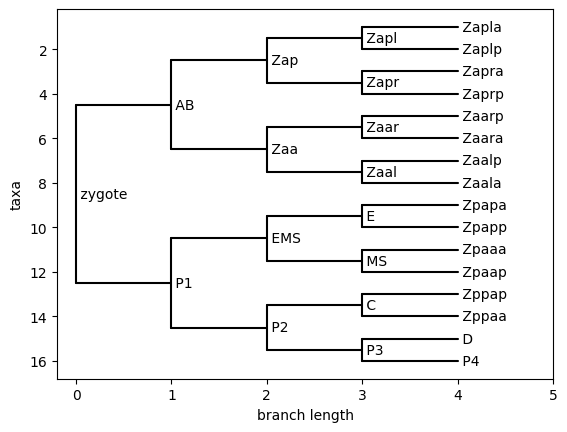

In [118]:
from Bio import Phylo
from Bio.Phylo.BaseTree import Clade
import matplotlib.pyplot as plt

# 노드 이름 매핑
node_name_map = {
    "Z": "zygote",
    "Za": "AB",
    "Zpa": "EMS",
    "Zpaa": "MS",
    "Zpap": "E",
    "Zppa": "C",
    "Zpppa": "D",
    "Zp": "P1",
    "Zpp": "P2",
    "Zppp": "P3",
    "Zpppp": "P4"
}

# 노드 이름 매핑 적용
def map_names(clade):
    if clade.name in node_name_map:
        clade.name = node_name_map[clade.name]
    for child in clade.clades:
        map_names(child)

# 깊이 제한 적용하여 새로운 트리 생성
def clone_tree_with_depth(clade, depth=0, max_depth=4):
    if depth > max_depth:
        return None
    new_clade = Clade(branch_length=clade.branch_length, name=clade.name)
    for child in clade.clades:
        cloned_child = clone_tree_with_depth(child, depth + 1, max_depth)
        if cloned_child:
            new_clade.clades.append(cloned_child)
    return new_clade

# 트리 읽기
tree = Phylo.read("nwk/answer/complete_tree.nwk", "newick")

# 이름 매핑
map_names(tree.root)

# 깊이 제한 적용
max_depth = 4
limited_root = clone_tree_with_depth(tree.root, max_depth=max_depth)
limited_tree = Phylo.BaseTree.Tree(root=limited_root)

# 그림으로 출력
plt.figure(figsize=(12, 8))
Phylo.draw(limited_tree, do_show=True)

- 전체 Tree topology만 다시 저장 후 시각화

# 2. Polytomy Analysis

## 2.1. Generate Artificial Polytomy
- In `complete_tree.nwk`, check whether `polytomy_size` leaved node exists.
- Choose one among them.
- Polytomize that node.

- Polytomy parameters

In [82]:
polytomy_size = 25
tree_sample_size = 100

- Load tree and check the number of daughters

In [83]:
from Bio import Phylo
import random
from collections import Counter
from Bio.Phylo.Newick import Clade
import copy

true_tree_path = "nwk/answer/complete_tree.nwk"
true_tree = Phylo.read(true_tree_path, "newick")

print("Total daughters: ", len(tree.get_terminals()))
print(*[f"{k} daughters: {v} nodes" 
        for k, v in sorted(Counter(len(c.clades) for c in tree.find_clades()).items())], 
      sep=", ")

Total daughters:  984
0 daughters: 984 nodes, 1 daughters: 164 nodes, 2 daughters: 983 nodes


- Function to find all nodes with `m` leaves

In [84]:
def find_nodes_with_m_leaves(clade, m):
    nodes = []
    def helper(node):
        if node.is_terminal():
            return 1
        leaf_count = sum(helper(c) for c in node.clades)
        if leaf_count == m:
            nodes.append(node)
        return leaf_count
    helper(clade)
    return nodes

- If there are more than 1 node with leaf size = `polytomy_size`, choose one among them.
- Make that node to polytomy.
- Save 
  - Original copy to `polytomy_removed_tree.nwk`
  - 

In [85]:
copy_tree = copy.deepcopy(true_tree)
nodes_with_m_leaves = find_nodes_with_m_leaves(copy_tree.root, polytomy_size)

print("Before polytomizing: Total daughters: ", len(copy_tree.get_terminals()))
print(*[f"{k} daughters: {v} nodes" 
    for k, v in sorted(Counter(len(c.clades) for c in copy_tree.find_clades()).items())], 
    sep=", ")

if len(nodes_with_m_leaves) == 0:
    print("\nUnable to polytomize!")
else:
    print("\nPolytomizing one of the subtree among {} trees...\n".format(len(nodes_with_m_leaves)))

    def count_children(node):
        counts = Counter()
        child_count = len(node.clades)
        counts[child_count] += 1
        
        for child in node.clades:
            counts.update(count_children(child))
        return counts

    child_counter = count_children(copy_tree.root)

    picked_node = random.choice(nodes_with_m_leaves)

    answer_subtree = copy.deepcopy(picked_node)
    # 리프 노드 이름 t1, t2, ...
    for i, leaf in enumerate(answer_subtree.get_terminals(), start=1):
        leaf.name = f"t{i}"

    # 내부 노드 이름 제거
    for n in answer_subtree.get_nonterminals():
        n.name = None

    # 모든 branch_length 제거 (재귀)
    def remove_branch_length(clade):
        clade.branch_length = None
        for child in clade.clades:
            remove_branch_length(child)

    remove_branch_length(answer_subtree)
    Phylo.write(answer_subtree, "nwk/answer/polytomy_removed_tree.nwk", "newick")

    # Newick 문자열로 가져오기
    from io import StringIO
    output = StringIO()
    Phylo.write(answer_subtree, output, "newick")
    newick_str = output.getvalue()

    # :0.00000 제거
    import re
    newick_str_no_branch = re.sub(r":0\.0+","", newick_str)

    # 파일로 저장
    with open("nwk/answer/polytomy_removed_tree.nwk","w") as f:
        f.write(newick_str_no_branch)

    def polytomize_node(node):
        leaves = node.get_terminals()
        node.clades = leaves

    polytomize_node(picked_node)
    print("After polytomizing: Total daughters: ", len(copy_tree.get_terminals()))
    print(*[f"{k} daughters: {v} nodes" 
        for k, v in sorted(Counter(len(c.clades) for c in copy_tree.find_clades()).items())], 
      sep=", ")

Before polytomizing: Total daughters:  984
0 daughters: 984 nodes, 1 daughters: 164 nodes, 2 daughters: 983 nodes

Polytomizing one of the subtree among 6 trees...

After polytomizing: Total daughters:  984
0 daughters: 984 nodes, 1 daughters: 155 nodes, 2 daughters: 959 nodes, 25 daughters: 1 nodes


## 2.2. Generate Trees for each Method

- As the resolved tree for polytomy, generate simulated trees for each method.
  - Birth-death model (BD)
  - Beta-splitting model (BT)
  - Kingman Coalescent model (KC)
  - Yule model (YL)
  - Uniform model (UF)

In [86]:
%%R -i polytomy_size -i tree_sample_size
library(ape)
library(poweRbal)

leaves <- polytomy_size
reps   <- tree_sample_size
path <- "nwk/simulation"
if (!dir.exists(path)) dir.create(path, recursive = TRUE)

# 모델과 파라미터를 리스트로 정의
models <- list(
  list(name="BD", type="BD", params=data.frame(birth=c(1,2), death=c(0,0.5))),
  list(name="BT", type="Beta", params=data.frame(beta=c(0.2,0.5))),
  list(name="KC", type="KC", params=NULL),
  list(name="YL", type="Yule", params=NULL),
  list(name="UF", type="Uniform", params=NULL)
)

for (m in models) {
  model <- m$name
  type  <- m$type
  params <- m$params
  
  if (type=="BD") {
    for (i in 1:nrow(params)) {
      b <- params$birth[i]
      d <- params$death[i]
      trees <- lapply(1:reps, function(j) genAltBirthDeathTree(n=leaves, BIRTHRATE=b, DEATHRATE=d, TRIES=1000))
      file_name <- sprintf("%s_b%.1f_d%.1f_l%d_r%d.nwk", model, b, d, leaves, reps)
      write.tree(trees, file=file.path(path, file_name))
      cat("Saved:", file_name, "\n")
    }
  } else if (type=="Beta") {
    for (i in 1:nrow(params)) {
      b <- params$beta[i]
      trees <- lapply(1:reps, function(j) genAldousBetaTree(n=leaves, BETA=b))
      file_name <- sprintf("%s_b%.1f_l%d_r%d.nwk", model, b, leaves, reps)
      write.tree(trees, file=file.path(path, file_name))
      cat("Saved:", file_name, "\n")
    }
  } else if (type=="KC") {
    trees <- lapply(1:reps, function(j) {
      tr <- rcoal(n=leaves)
      tr$edge.length <- NULL
      tr
    })
    file_name <- sprintf("%s_l%d_r%d.nwk", model, leaves, reps)
    write.tree(trees, file=file.path(path, file_name))
    cat("Saved:", file_name, "\n")
    
  } else if (type=="Yule") {
    trees <- lapply(1:reps, function(j) genAldousBetaTree(n=leaves, BETA=0))
    file_name <- sprintf("%s_l%d_r%d.nwk", model, leaves, reps)
    write.tree(trees, file=file.path(path, file_name))
    cat("Saved:", file_name, "\n")
    
  } else if (type=="Uniform") {
    trees <- lapply(1:reps, function(j) genAldousBetaTree(n=leaves, BETA=-1.5))
    file_name <- sprintf("%s_l%d_r%d.nwk", model, leaves, reps)
    write.tree(trees, file=file.path(path, file_name))
    cat("Saved:", file_name, "\n")
  }
}

Saved: BD_b1.0_d0.0_l25_r100.nwk 
Saved: BD_b2.0_d0.5_l25_r100.nwk 
Saved: BT_b0.2_l25_r100.nwk 
Saved: BT_b0.5_l25_r100.nwk 
Saved: KC_l25_r100.nwk 
Saved: YL_l25_r100.nwk 
Saved: UF_l25_r100.nwk 


- Rename generated trees for easier use.

In [87]:
import os
from glob import glob

tree_folder = "nwk/simulation"
prefixes = ["BD", "BT", "KC", "YL", "UF"]

# 모델별로 파일 리스트 만들기
all_files = sorted(glob(os.path.join(tree_folder, "*.nwk")))

# 각 모델별로 그룹화
model_files = []
for p in prefixes:
    files = sorted([f for f in all_files 
                    if os.path.basename(f).startswith(p) 
                    and f"l{polytomy_size}" in os.path.basename(f)])
    model_files.extend(files)  # 순서대로 하나의 리스트에 추가

# model_1, model_2, ... 변수 생성
for i, fpath in enumerate(model_files, start=1):
    globals()[f"model_{i}"] = fpath

# models 리스트에 담기
models = [globals()[f"model_{i}"] for i in range(1, len(model_files)+1)]

# 확인
for i, f in enumerate(models, start=1):
    print(f"model_{i}: {f}")

model_1: nwk/simulation/BD_b1.0_d0.0_l25_r100.nwk
model_2: nwk/simulation/BD_b2.0_d0.5_l25_r100.nwk
model_3: nwk/simulation/BT_b0.2_l25_r100.nwk
model_4: nwk/simulation/BT_b0.5_l25_r100.nwk
model_5: nwk/simulation/KC_l25_r100.nwk
model_6: nwk/simulation/YL_l25_r100.nwk
model_7: nwk/simulation/UF_l25_r100.nwk


## 2.3. Calculate & Plot Statistics

### 2.3.1. 1D Statistics
- Colless Index
- Sackins Index
- Tree Height
- Root Splitting Ratio

- Define Functions for 1D Statistics

In [88]:
import dendropy
import math

def colless_index(tree):
    def count_leaves(node):
        if node.is_leaf():
            return 1
        return sum(count_leaves(c) for c in node.child_nodes())

    def colless_node(node):
        if node.is_leaf() or len(node.child_nodes()) < 2:
            return 0
        left, right = node.child_nodes()[:2]  # binary assumption
        nl = count_leaves(left)
        nr = count_leaves(right)
        return abs(nl - nr) + colless_node(left) + colless_node(right)

    return colless_node(tree.seed_node)

def sackins_index(tree):
    def leaf_depth_sum(node, depth=0):
        if node.is_leaf():
            return depth
        return sum(leaf_depth_sum(c, depth+1) for c in node.child_nodes())

    return leaf_depth_sum(tree.seed_node)

def tree_height(tree):
    max_depth = 0
    def dfs(nd, depth):
        nonlocal max_depth
        if nd.is_leaf():
            max_depth = max(max_depth, depth)
        for c in nd.child_nodes():
            dfs(c, depth+1)
    dfs(tree.seed_node, 0)
    return max_depth

def root_split_ratio_x(tree):
    root_children = tree.seed_node.child_nodes()
    if len(root_children) >= 2:
        n_left = len(root_children[0].leaf_nodes())
        n_right = len(root_children[1].leaf_nodes())
    elif len(root_children) == 1:
        n_left = len(root_children[0].leaf_nodes())
        n_right = 0
    else:
        n_left = 0
        n_right = 0

    # 왼쪽을 항상 작은 쪽으로
    if n_left > n_right:
        n_left, n_right = n_right, n_left

    return n_left  # x 값만 반환

- Calculate 1D Statistics

In [89]:
import dendropy
import pandas as pd

# 모델별 파일 리스트
# models = [model_1, model_2, ...] 이미 존재한다고 가정
model_labels = [f"model_{i}" for i in range(1, len(models)+1)]

# 데이터프레임 초기화
df_stats = pd.DataFrame(columns=["Model", "Colless", "Sackin", "Height", "RootSplit"])

for label, fpath in zip(model_labels, models):
    # 파일 하나에 여러 트리가 있으면 TreeList로 읽기
    trees = dendropy.TreeList.get(path=fpath, schema="newick", preserve_underscores=True)
    for tree in trees:
        df_stats.loc[len(df_stats)] = {
            "Model": label,
            "Colless": colless_index(tree),
            "Sackin": sackins_index(tree),
            "Height": tree_height(tree),
            "RootSplit": root_split_ratio_x(tree)
        }

# polytomy_removed_tree.nwk 통계 계산
answer_tree_path = "nwk/answer/polytomy_removed_tree.nwk"
answer_tree = dendropy.Tree.get(path=answer_tree_path, schema="newick", preserve_underscores=True)

answer_stats = {
    "Colless": colless_index(answer_tree),
    "Sackin": sackins_index(answer_tree),
    "Height": tree_height(answer_tree),
    "RootSplit": root_split_ratio_x(answer_tree)
}

# df_stats 확인
print(df_stats.head())

     Model  Colless  Sackin  Height  RootSplit
0  model_1       25     123       6         12
1  model_1       28     124       7         12
2  model_1       55     137       8          5
3  model_1       47     135       9         10
4  model_1       54     142       8          3


- Plot 1D Statistics

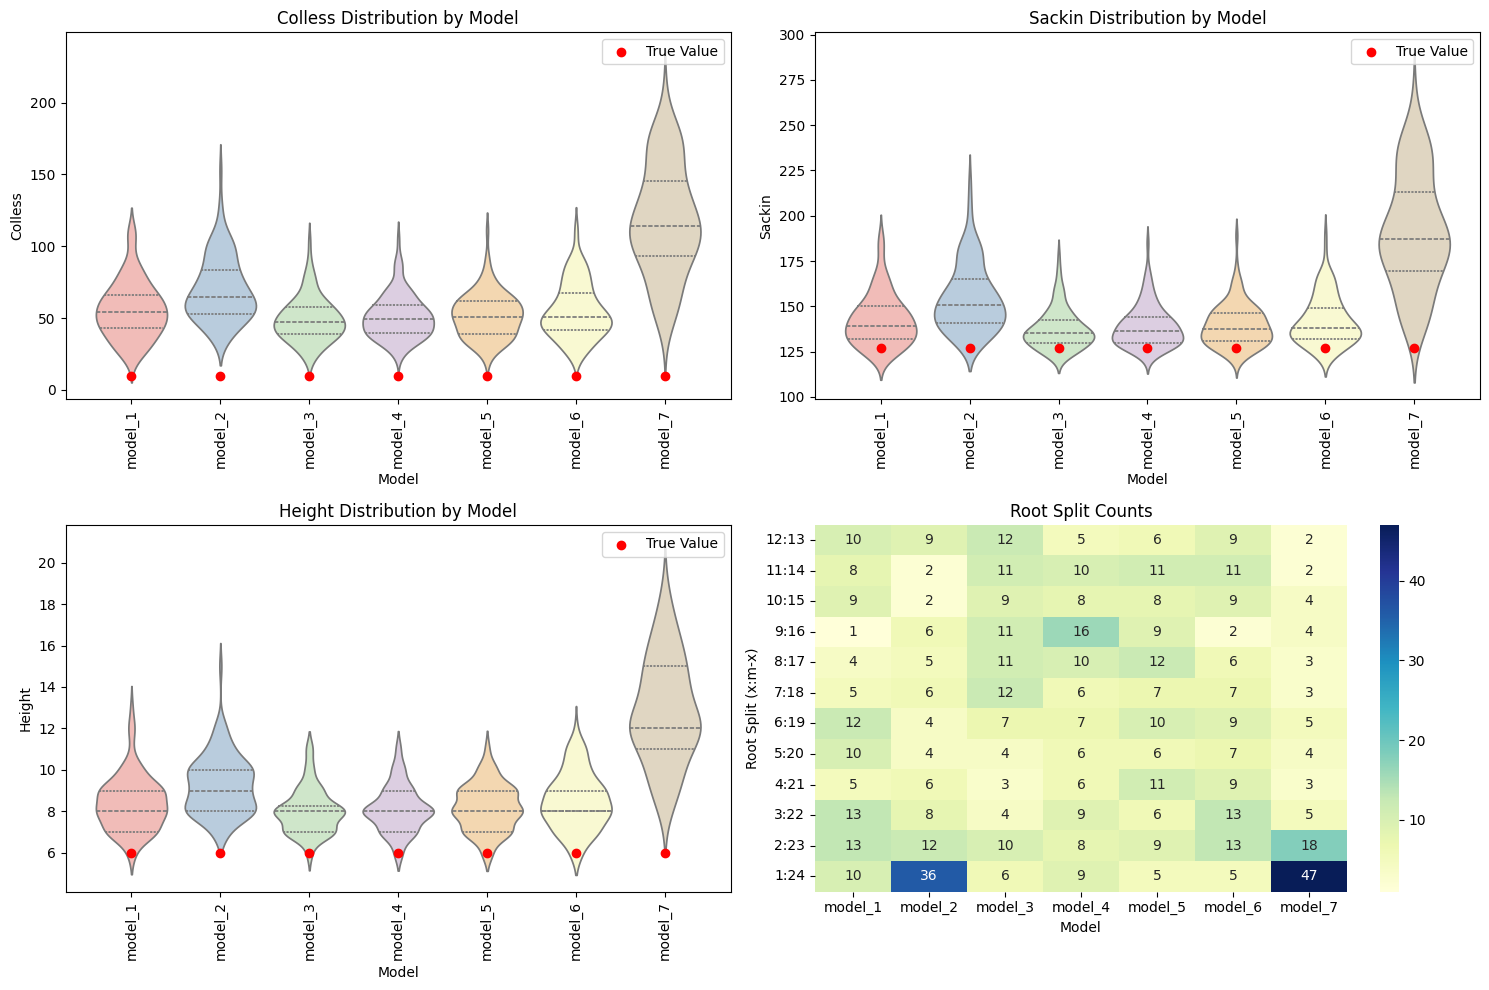

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 그릴 메트릭 설정
# -----------------------------
metrics = ["Colless", "Sackin", "Height"]
model_labels = df_stats['Model'].unique()

# -----------------------------
# 2. 2x2 Figure 설정
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# -----------------------------
# 3. Violin plots for Colless, Sackin, Height
# -----------------------------
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.violinplot(
        x="Model",
        y=metric,
        data=df_stats,
        inner="quartile",
        order=model_labels,
        palette="Pastel1",
        ax=ax
    )
    # 정답 트리 표시
    ax.scatter(
        x=range(len(model_labels)),
        y=[answer_stats[metric]]*len(model_labels),
        color='red',
        zorder=10,
        label="True Value"
    )
    ax.set_title(f"{metric} Distribution by Model")
    ax.set_xticks(range(len(model_labels)))
    ax.set_xticklabels(model_labels, rotation=90)

    ax.legend()

# -----------------------------
# 4. Heatmap for Root Split
# -----------------------------
m = polytomy_size  # 전체 leaf 수

# pivot table: 행=RootSplit, 열=Model
heat_data = df_stats.pivot_table(
    index='RootSplit',
    columns='Model',
    aggfunc='size',
    fill_value=0
)

# y축 정렬 (1이 가장 아래)
heat_data = heat_data.sort_index(ascending=False)

ax = axes[1,1]
sns.heatmap(
    heat_data,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    ax=ax
)

# y축 tick을 x:(m-x) 형태로 변환
y_labels = [f"{x}:{m-x}" for x in heat_data.index]
ax.set_yticklabels(y_labels, rotation=0)

ax.set_title("Root Split Counts")
ax.set_xlabel("Model")
ax.set_ylabel("Root Split (x:m-x)")

plt.tight_layout()
plt.show()

### 2.3.2. 2D Statistics

#### 2.3.2.1. Calculation

##### 2.3.2.1.1 RF Distance

- Calculate 2D statistics (RF distance)

In [91]:
from dendropy import Tree, TreeList, TaxonNamespace
from dendropy.calculate import treecompare
import matplotlib.pyplot as plt

# -----------------------------
# 1. 정답 트리 로드
# -----------------------------
answer_tree_path = "nwk/answer/polytomy_removed_tree.nwk"

# 공통 TaxonNamespace
taxa = TaxonNamespace()

# 정답 트리 로드
answer_tree = Tree.get(path=answer_tree_path, schema="newick", taxon_namespace=taxa, preserve_underscores=True)
for e in answer_tree.postorder_edge_iter():
    e.length = None  # edge lengths 제거

# -----------------------------
# 2. 모델별 트리 RF 거리 계산
# -----------------------------
rf_distances = []
nrf_distances = []

for model_files in models:  # models 리스트, 각 요소는 파일 경로 리스트
    if isinstance(model_files, str):
        model_files = [model_files]
    
    dists = []
    n_dists = []
    for f in model_files:
        # 파일 내 모든 트리 읽기
        trees = TreeList.get(path=f, schema="newick", taxon_namespace=taxa, preserve_underscores=True)
        for t in trees:
            # edge lengths 제거
            for e in t.postorder_edge_iter():
                e.length = None
            # RF 거리 계산
            rf = treecompare.symmetric_difference(answer_tree, t)
            n_leaves = len(t.leaf_nodes())
            rf_norm = rf / (2 * (n_leaves - 3))

            dists.append(rf)
            n_dists.append(rf_norm)
    rf_distances.append(dists)
    nrf_distances.append(n_dists)

##### 2.3.2.1.2. Quartet Distance

- Calculate 2D statistics (Quartet distance)

In [92]:
%%R -i answer_tree_path -i models -o qds -o nqds

library(ape)
library(Quartet)

# 정답 트리 읽기
answer_tree <- read.tree(answer_tree_path)

qds <- list()   # 각 파일별 Quartet Distance
nqds <- list()  # 정규화된 QD

for (i in seq_along(models)) {
  file_path <- models[[i]]  # 파일 경로
  tree_lines <- readLines(file_path)  # 파일 내 모든 트리 (한 줄에 하나)
  
  qd_vec <- numeric(length(tree_lines))
  nqd_vec <- numeric(length(tree_lines))
  
  for (j in seq_along(tree_lines)) {
    tr_text <- tree_lines[j]
    
    # Newick 문자열을 객체로 읽기
    tr <- read.tree(text = tr_text)
    num_leaves <- length(tr$tip.label)
    
    # Quartet distance 계산
    # 파일 경로 대신 임시 파일 필요
    tmp_file <- tempfile(fileext = ".nwk")
    writeLines(tr_text, tmp_file)
    qd_val <- QuartetDistance(answer_tree_path, tmp_file)
    unlink(tmp_file)
    
    qd_vec[j] <- qd_val
    nqd_vec[j] <- qd_val / choose(num_leaves, 4)
  }
  
  qds[[i]] <- qd_vec
  nqds[[i]] <- nqd_vec
}
print(length(qds[[1]]))
print(length(nqds[[1]]))

[1] 100
[1] 100


#### 2.3.2.2. Plot

- Plot 2D Statistics

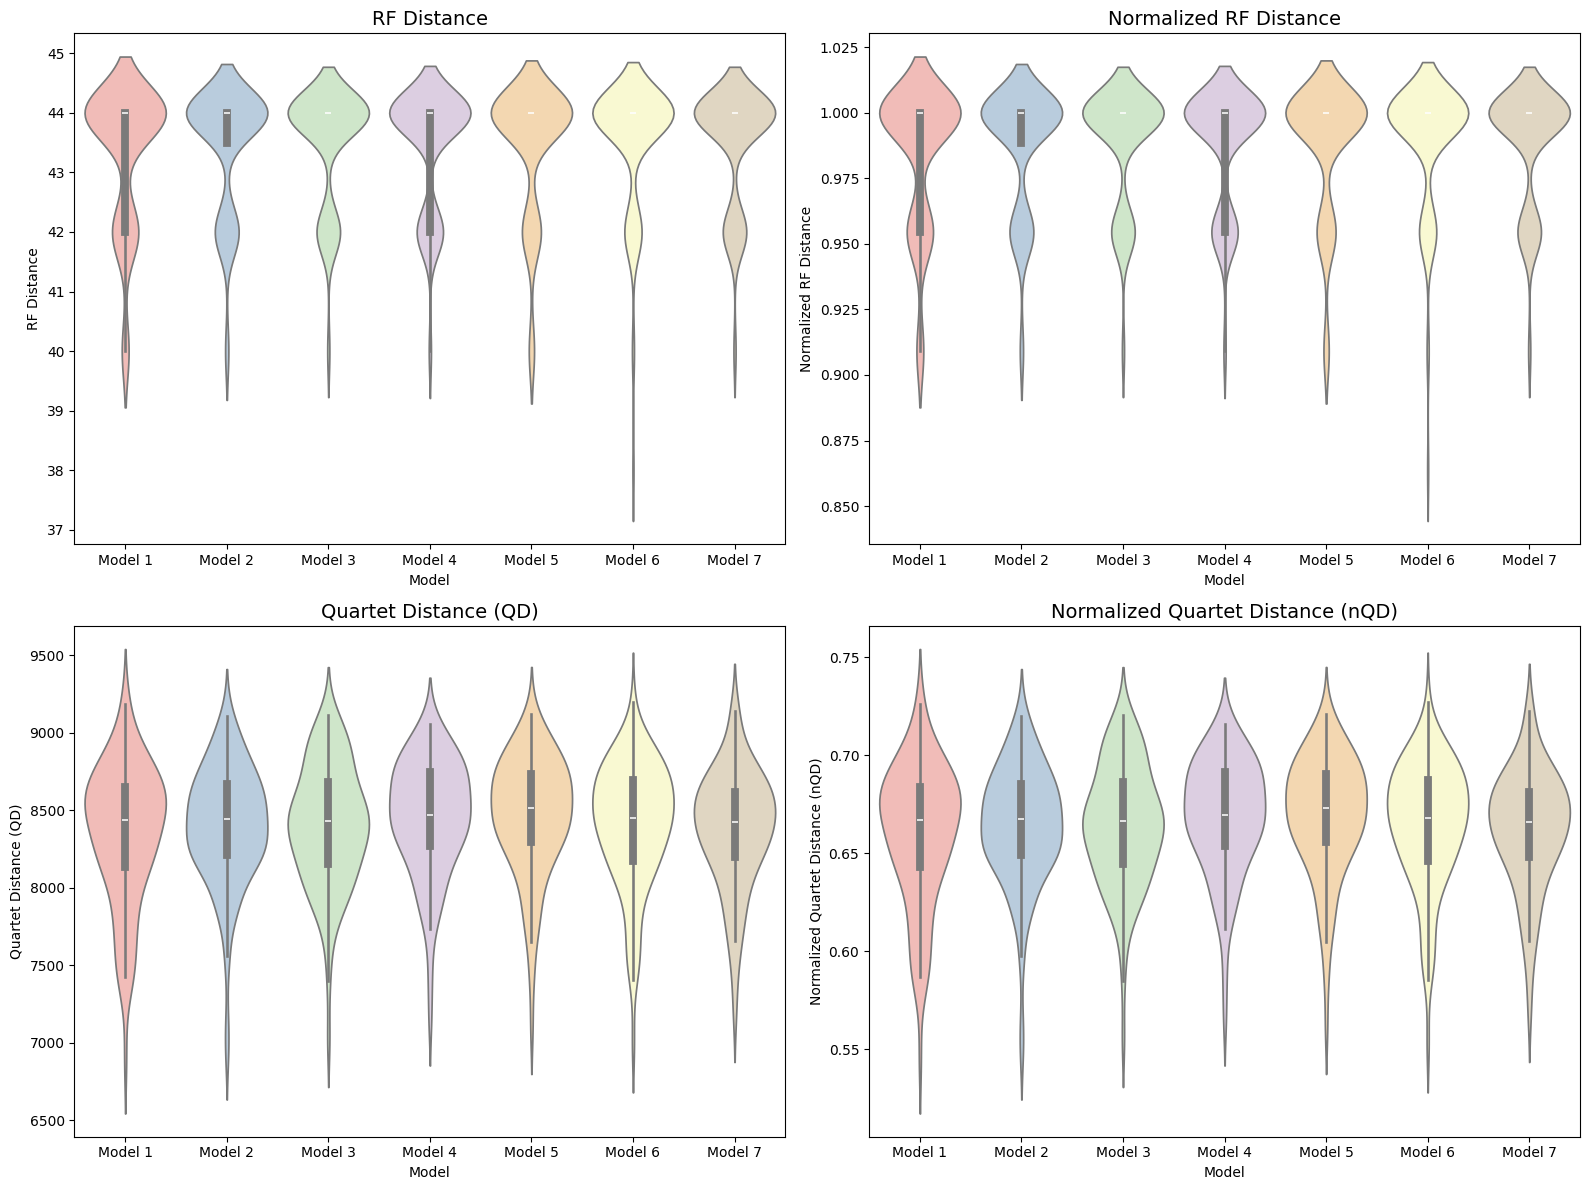

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

# 경고 숨기기
warnings.filterwarnings("ignore")

# subplot 설정
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # 1차원 배열로

# 그릴 데이터와 이름
data_metrics = [
    (rf_distances, "RF Distance"),
    (nrf_distances, "Normalized RF Distance"),
    (qds, "Quartet Distance (QD)"),
    (nqds, "Normalized Quartet Distance (nQD)")
]

for ax, (data_list, metric_name) in zip(axes, data_metrics):
    # 모델 이름
    model_labels = [f"Model {i+1}" for i in range(len(data_list))]
    
    # long-form 데이터프레임 생성
    df = pd.DataFrame({
        "Value": [v for model in data_list for v in model],
        "Model": [model_labels[i] for i, model in enumerate(data_list) for _ in model]
    })
    
    sns.violinplot(x="Model", y="Value", data=df, inner="box", palette="Pastel1", ax=ax)
    ax.set_title(metric_name, fontsize=14)
    ax.set_xlabel("Model")
    ax.set_ylabel(metric_name)

plt.tight_layout()
plt.show()

## 2.4. GSM Distribution Estimation

- Required function

In [94]:
def resolve_polytomy(clade):
    """Polytomy를 binary로 변환"""
    if clade.is_terminal():
        return
    
    while len(clade.clades) > 2:
        # 두 개 자식만 남기고 나머지는 새로운 내부 노드로 묶기
        first = clade.clades.pop(0)
        second = clade.clades.pop(0)
        new_internal = Clade()
        new_internal.clades = [first, second]
        clade.clades.insert(0, new_internal)
    
    # 재귀 적용
    for child in clade.clades:
        resolve_polytomy(child)

### 2.4.1. Unweighted Distribution
- Read original tree.
- Check the split-ratio distribution (=`Unweighted`)

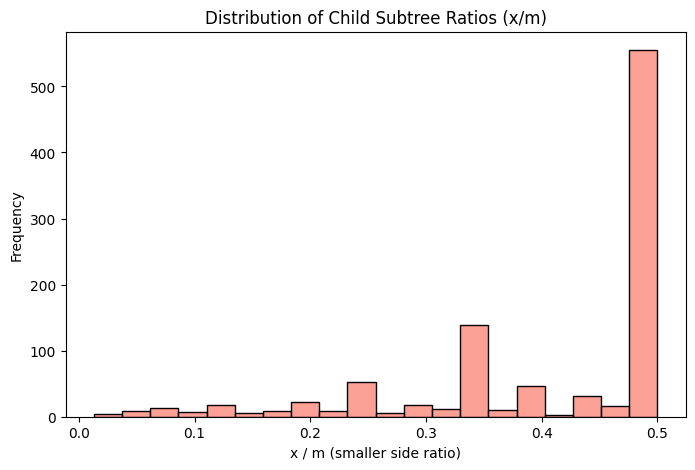

In [95]:
from Bio import Phylo
import matplotlib.pyplot as plt
import seaborn as sns

# 트리 불러오기 (예시: Newick 파일)
temp_tree = copy.deepcopy(true_tree)
# resolve_polytomy(temp_tree.root)

ratios = []

def count_leaves(clade):
    """재귀적으로 leaf 개수 세기"""
    if clade.is_terminal():
        return 1
    return sum(count_leaves(child) for child in clade.clades)

# 내부 노드 순회
for clade in temp_tree.root.find_clades(order="postorder"):
    if not clade.is_terminal() and len(clade.clades) == 2:  # binary node만
        left, right = clade.clades
        left_leaves = count_leaves(left)
        right_leaves = count_leaves(right)
        m = left_leaves + right_leaves
        x = min(left_leaves, right_leaves)
        ratio = x / m
        ratios.append(ratio)

# -----------------------------
# 분포 시각화
# -----------------------------
plt.figure(figsize=(8, 5))
sns.histplot(ratios, bins=20, color="salmon", edgecolor="black")
plt.title("Distribution of Child Subtree Ratios (x/m)")
plt.xlabel("x / m (smaller side ratio)")
plt.ylabel("Frequency")
plt.show()

### 2.4.2. Weighted Distribution
- Read original tree.
- Weight를 frequency에 부여해 distribution 확인 (=`weighted`)
  - w_root = 1
  - w_Za = 3/8, w_Zp = 5/8 if root split ratio = 3:5
    - w_Zaa = 3/8 * 2/8, w_Zap = 3/8 * 6/8 if split ratio of Za = 2:6

Text(0.5, 1.0, 'Weighted Distribution of Child Subtree Ratios (x/m)')

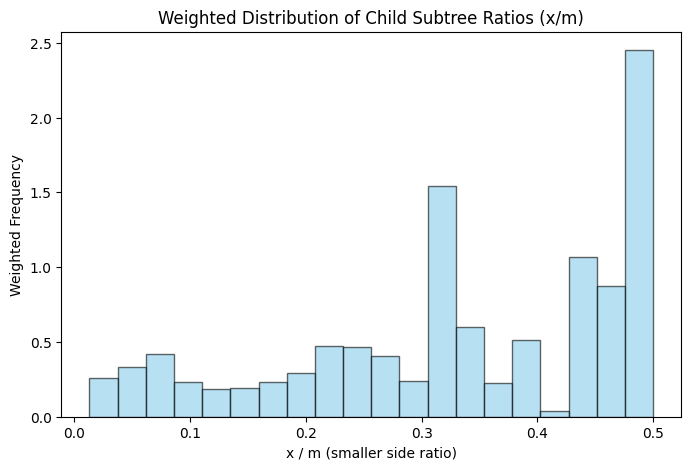

In [96]:
from Bio import Phylo
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# -----------------------------
# 트리 불러오기
# -----------------------------
temp_tree = copy.deepcopy(true_tree)  # 예시 트리, Newick 불러온 후
# resolve_polytomy(tree.root)      # polytomy 제거

# -----------------------------
# 1. Bottom-up leaf count 계산
# -----------------------------
def compute_leaf_counts(node):
    """각 노드에 leaf 개수 저장 (bottom-up)"""
    if node.is_terminal():
        node.num_leaves = 1
    else:
        node.num_leaves = sum(compute_leaf_counts(child) for child in node.clades)
    return node.num_leaves

compute_leaf_counts(temp_tree.root)

# -----------------------------
# 2. Top-down weighted ratio 계산
# -----------------------------
ratios = []
weights = []

def collect_ratios(node, parent_weight=1.0):
    """top-down으로 weight 전달하며 ratio 수집"""
    if node.is_terminal() or len(node.clades) != 2:
        return

    left, right = node.clades
    left_leaves = left.num_leaves
    right_leaves = right.num_leaves
    m = left_leaves + right_leaves
    x = min(left_leaves, right_leaves)
    ratio = x / m

    # 현재 노드의 weight
    left_weight = parent_weight * (left_leaves / m)
    right_weight = parent_weight * (right_leaves / m)

    # ratio와 weight 저장
    ratios.append(ratio)
    weights.append(parent_weight)  # frequency 계산 시 곱할 weight

    # 재귀 호출
    collect_ratios(left, left_weight)
    collect_ratios(right, right_weight)

collect_ratios(temp_tree.root)

import numpy as np
from scipy.stats import gaussian_kde

# 리스트 → numpy 배열
ratios_arr = np.array(ratios)
weights_arr = np.array(weights)

# -----------------------------
# 1. Weighted histogram
# -----------------------------
plt.figure(figsize=(8,5))
plt.hist(ratios_arr, bins=20, weights=weights_arr, color='skyblue', edgecolor='black', alpha=0.6)
plt.xlabel("x / m (smaller side ratio)")
plt.ylabel("Weighted Frequency")
plt.title("Weighted Distribution of Child Subtree Ratios (x/m)")

### 2.4.3. Frequency based weight (Ongoing)

## 2.5. GSM Tree Generation
- Distribution from given data

- polytomy가 아닌 트리로부터 GSM의 distribution 계산
- `unweighted`, `weighted`에서 나누는 비율 sampling하기

In [97]:
import numpy as np

# 이미 계산된 ratios와 weights를 사용한다고 가정
# ratios: list of x/m
# weights: list of top-down weight

ratios_arr = np.array(ratios)
weights_arr = np.array(weights)

# -----------------------------
# 1. Unweighted 샘플링 (대칭 포함)
# -----------------------------
def sample_ratio_unweighted_symmetric(size=1):
    samples = np.random.choice(ratios_arr, size=size)
    # 50% 확률로 1 - ratio로 뒤집기
    flip = np.random.rand(size) < 0.5
    samples[flip] = 1 - samples[flip]
    return samples

# -----------------------------
# 2. Weighted 샘플링 (대칭 포함)
# -----------------------------
def sample_ratio_weighted_symmetric(size=1):
    probs = weights_arr / np.sum(weights_arr)
    samples = np.random.choice(ratios_arr, size=size, p=probs)
    flip = np.random.rand(size) < 0.5
    samples[flip] = 1 - samples[flip]
    return samples

- `weighted`, `unweighted`로부터 트리 만들기 및 저장

In [98]:
from Bio.Phylo.Newick import Clade, Tree
import numpy as np

# -----------------------------
# 1. symmetric ratio 샘플링 함수
# -----------------------------
def sample_ratio_unweighted_symmetric(size=1):
    """
    Unweighted sampling, symmetric around 0.5
    """
    samples = np.random.choice(ratios_arr, size=size)
    flip = np.random.rand(size) < 0.5
    samples[flip] = 1 - samples[flip]
    return samples

def sample_ratio_weighted_symmetric(size=1):
    """
    Weighted sampling with symmetric flipping
    """
    probs = weights_arr / np.sum(weights_arr)
    samples = np.random.choice(ratios_arr, size=size, p=probs)
    flip = np.random.rand(size) < 0.5
    samples[flip] = 1 - samples[flip]
    return samples

# -----------------------------
# 2. 재귀적으로 트리 생성 (안전하게)
# -----------------------------
def build_tree_general(n_leaves, sample_func, leaf_counter):
    if n_leaves == 1:
        leaf_name = f"t{leaf_counter[0]}"
        leaf_counter[0] += 1
        return Clade(name=leaf_name)

    # ratio 샘플링
    ratio = sample_func(size=1)[0]

    # leaf 수 계산
    left_leaves = int(round(n_leaves * ratio))
    right_leaves = n_leaves - left_leaves

    # 한쪽이 0이면 최소 1로 보정
    if left_leaves == 0:
        left_leaves = 1
        right_leaves = n_leaves - 1
    elif right_leaves == 0:
        right_leaves = 1
        left_leaves = n_leaves - 1

    left_clade = build_tree_general(left_leaves, sample_func, leaf_counter)
    right_clade = build_tree_general(right_leaves, sample_func, leaf_counter)

    return Clade(clades=[left_clade, right_clade])

# -----------------------------
# 3. branch length 없는 Newick 생성
# -----------------------------
def clade_to_newick(clade):
    if clade.is_terminal():
        return clade.name
    else:
        subtrees = [clade_to_newick(c) for c in clade.clades]
        return f"({','.join(subtrees)})"

def tree_to_newick_no_branchlength(tree):
    return clade_to_newick(tree.root) + ";"

# -----------------------------
# 4. 트리 생성 & 파일 저장
# -----------------------------
def generate_trees(n_trees=100, n_leaves=10, sample_func=None, filename="trees.nwk"):
    trees_list = []
    with open(filename, "w") as f:
        for i in range(n_trees):
            leaf_counter = [1]  # t1부터 시작
            tree = Tree(root=build_tree_general(n_leaves, sample_func, leaf_counter))
            trees_list.append(tree)
            f.write(tree_to_newick_no_branchlength(tree) + "\n")
    print(f"{n_trees} trees saved to {filename}")
    return trees_list

# -----------------------------
# 5. 사용 예시
# -----------------------------
n_trees = tree_sample_size  # 총 생성할 트리 수
n_leaves = polytomy_size    # 각 트리 leaf 수

# Unweighted version
trees_unweighted = generate_trees(
    n_trees=n_trees,
    n_leaves=n_leaves,
    sample_func=sample_ratio_unweighted_symmetric,
    filename="nwk/simulation/trees_unweighted.nwk"
)

# Weighted version
trees_weighted = generate_trees(
    n_trees=n_trees,
    n_leaves=n_leaves,
    sample_func=sample_ratio_weighted_symmetric,
    filename="nwk/simulation/trees_weighted.nwk"
)

100 trees saved to nwk/simulation/trees_unweighted.nwk
100 trees saved to nwk/simulation/trees_weighted.nwk


## 2.6. GSM Tree Statistics

### 2.6.1. 1D Statistics

#### 2.6.1.1. Calculation

- 새로 만든 트리 load + 1D statistic 계산

In [99]:
import dendropy
import pandas as pd

# -----------------------------
# 1. 공통 TaxonNamespace
# -----------------------------
taxa = dendropy.TaxonNamespace()

# -----------------------------
# 2. 새로 생성한 Unweighted / Weighted 트리 읽기 (dendropy)
# -----------------------------
trees_unweighted_dendropy = dendropy.TreeList.get(
    path="nwk/simulation/trees_unweighted.nwk",
    schema="newick",
    taxon_namespace=taxa,
    preserve_underscores=True
)

trees_weighted_dendropy = dendropy.TreeList.get(
    path="nwk/simulation/trees_weighted.nwk",
    schema="newick",
    taxon_namespace=taxa,
    preserve_underscores=True
)

# -----------------------------
# 3. 새 트리 통계 계산
# -----------------------------
records_new = []

# Unweighted
for tree in trees_unweighted_dendropy:
    records_new.append({
        "Model": "Unweighted",
        "Colless": colless_index(tree),
        "Sackin": sackins_index(tree),
        "Height": tree_height(tree),
        "RootSplit": root_split_ratio_x(tree)
    })

# Weighted
for tree in trees_weighted_dendropy:
    records_new.append({
        "Model": "Weighted",
        "Colless": colless_index(tree),
        "Sackin": sackins_index(tree),
        "Height": tree_height(tree),
        "RootSplit": root_split_ratio_x(tree)
    })

df_new_stats = pd.DataFrame(records_new)

# -----------------------------
# 4. 기존 모델 + 새 트리 통계 합치기
# -----------------------------
df_combined = pd.concat([df_stats, df_new_stats], ignore_index=True)

# -----------------------------
# 5. 결과 확인
# -----------------------------
print(df_combined.head())

     Model  Colless  Sackin  Height  RootSplit
0  model_1       25     123       6         12
1  model_1       28     124       7         12
2  model_1       55     137       8          5
3  model_1       47     135       9         10
4  model_1       54     142       8          3


#### 2.6.1.2. Plot

- 새로 만든 tree의 1D statistic plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


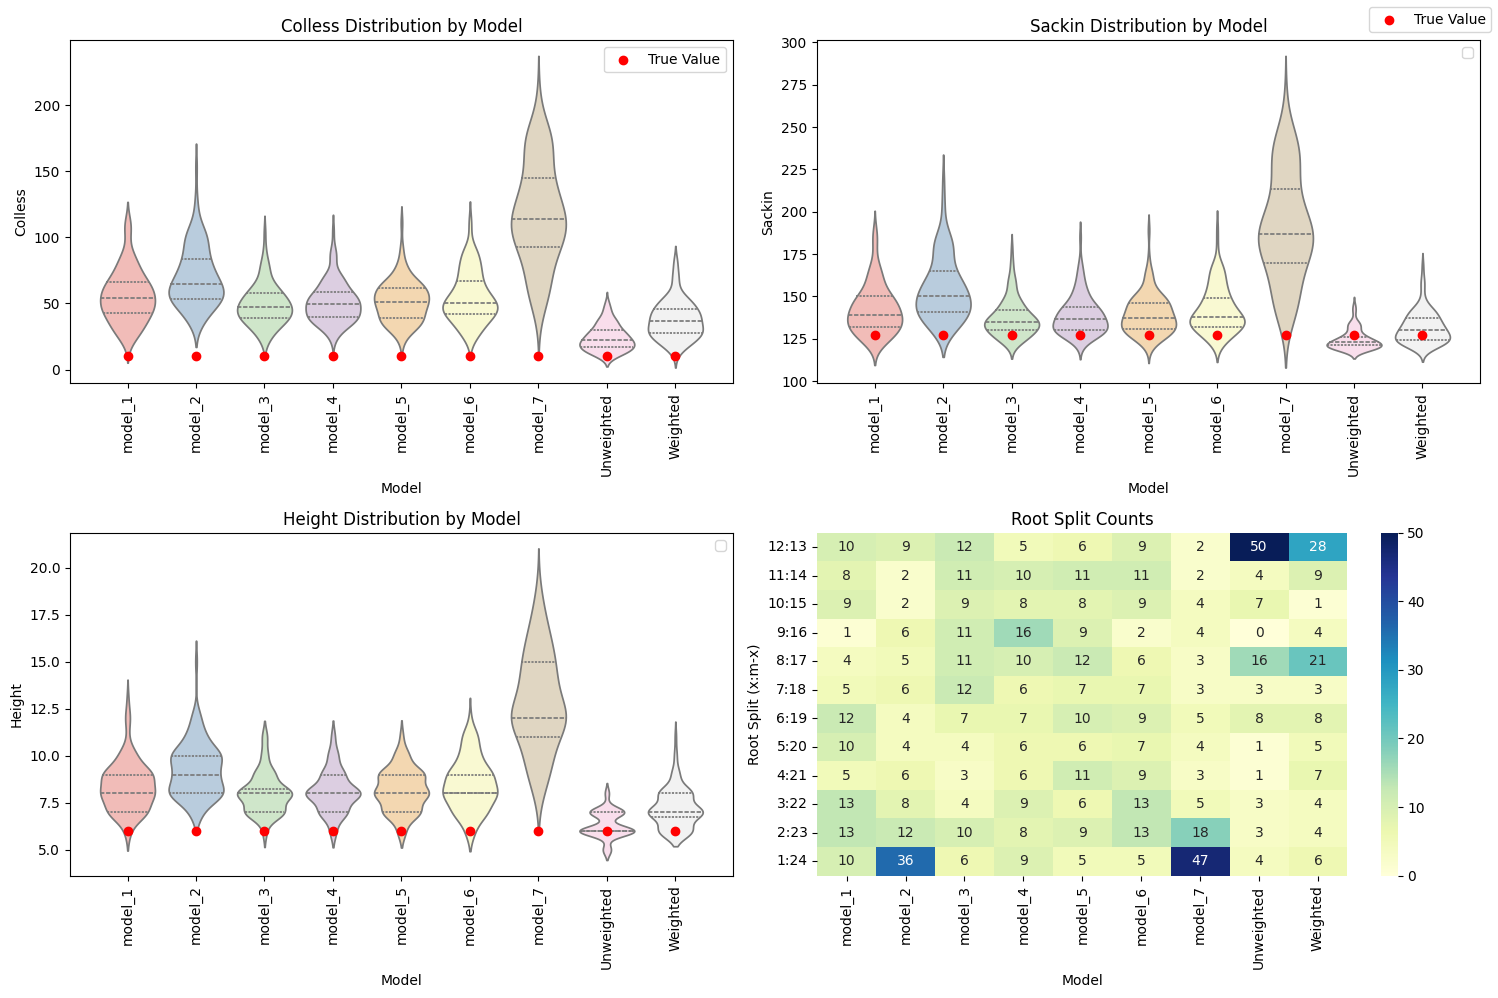

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------
# 1. 그릴 메트릭 설정
# -----------------------------
metrics = ["Colless", "Sackin", "Height"]
m = polytomy_size  # 전체 leaf 수

# 모델 순서: weighted, unweighted을 마지막으로
model_order_raw = list(df_combined['Model'].unique())
special = ["Unweighted", "Weighted"]
model_order = [m for m in model_order_raw if m not in special] + special

# -----------------------------
# 2. Figure 설정 (2x2)
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# -----------------------------
# 3. Violin plots
# -----------------------------
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.violinplot(
        x="Model",
        y=metric,
        data=df_combined,
        inner="quartile",
        palette="Pastel1",
        order=model_order,
        ax=ax
    )
    # 정답 트리 값 표시
    ax.scatter(
        x=range(len(model_order)),
        y=[answer_stats[metric]]*len(model_order),
        color='red',
        zorder=10,
        label="True Value" if i == 0 else None
    )
    ax.set_title(f"{metric} Distribution by Model")
    ax.set_xticklabels(model_order, rotation=90)

    ax.legend()

# -----------------------------
# 4. Heatmap for Root Split
# -----------------------------
df_combined['X'] = df_combined['RootSplit'].astype(int)

# pivot table: 행=X, 열=Model (모델 순서 반영)
heat_data = df_combined.pivot_table(
    index='X',
    columns='Model',
    aggfunc='size',
    fill_value=0
).reindex(columns=model_order)

# y축을 뒤집기 (1이 아래쪽)
heat_data = heat_data.sort_index(ascending=False)

ax = axes[1, 1]
sns.heatmap(
    heat_data,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    ax=ax
)

# y축 tick을 x:(m-x) 형태로 변환
y_labels = [f"{x}:{m-x}" for x in heat_data.index]
ax.set_yticklabels(y_labels, rotation=0)

ax.set_title("Root Split Counts")
ax.set_xlabel("Model")
ax.set_ylabel("Root Split (x:m-x)")

# -----------------------------
# 5. Layout 정리
# -----------------------------
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()

### 2.6.2. 2D Statistics

#### 2.6.2.1. Calculation

##### 2.6.2.1.1. RF Distance

- Tree load
- 2D tree statistic 계산

- RF distance, normalized RF distance 계산
  - Original Tree의 topology와 비교

In [101]:
from dendropy.calculate import treecompare

# 정답 트리
answer_tree_path = "nwk/answer/polytomy_removed_tree.nwk"
answer_tree = dendropy.Tree.get(
    path=answer_tree_path,
    schema="newick",
    taxon_namespace=taxa,
    preserve_underscores=True
)
for e in answer_tree.postorder_edge_iter():
    e.length = None  # edge lengths 제거

# 새로운 리스트 초기화
rf_distances_new = []
nrf_distances_new = []

# Unweighted
dists, n_dists = [], []
for t in trees_unweighted_dendropy:
    for e in t.postorder_edge_iter():
        e.length = None
    rf = treecompare.symmetric_difference(answer_tree, t)
    nrf = rf / (2 * (len(t.leaf_nodes()) - 3))
    dists.append(rf)
    n_dists.append(nrf)
rf_distances_new.append(dists)
nrf_distances_new.append(n_dists)

# Weighted
dists, n_dists = [], []
for t in trees_weighted_dendropy:
    for e in t.postorder_edge_iter():
        e.length = None
    rf = treecompare.symmetric_difference(answer_tree, t)
    nrf = rf / (2 * (len(t.leaf_nodes()) - 3))
    dists.append(rf)
    n_dists.append(nrf)
rf_distances_new.append(dists)
nrf_distances_new.append(n_dists)

##### 2.6.2.1.2. Quartet Distance

In [102]:
models_new_only = [
    "nwk/simulation/trees_unweighted.nwk",
    "nwk/simulation/trees_weighted.nwk"
]

- Quartet Distance 계산 (그냥, normalized)

In [103]:
%%R -i answer_tree_path -i models_new_only -o qds_new -o nqds_new
library(ape)
library(Quartet)

answer_tree <- read.tree(answer_tree_path)

qds_new <- list()
nqds_new <- list()

for (i in seq_along(models_new_only)) {
  file_path <- models_new_only[[i]]
  tree_lines <- readLines(file_path)
  
  qd_vec <- numeric(length(tree_lines))
  nqd_vec <- numeric(length(tree_lines))
  
  for (j in seq_along(tree_lines)) {
    tr_text <- tree_lines[j]
    
    tmp_file <- tempfile(fileext = ".nwk")
    writeLines(tr_text, tmp_file)
    
    qd_val <- QuartetDistance(answer_tree_path, tmp_file)
    nqd_val <- qd_val / choose(length(read.tree(text=tr_text)$tip.label), 4)
    
    unlink(tmp_file)
    
    qd_vec[j] <- qd_val
    nqd_vec[j] <- nqd_val
  }
  
  qds_new[[i]] <- qd_vec
  nqds_new[[i]] <- nqd_vec
}

#### 2.6.2.2. Plot

- 데이터 통합

In [104]:
rf_distances_all = rf_distances + rf_distances_new
nrf_distances_all = nrf_distances + nrf_distances_new
qds_all = qds + qds_new
nqds_all = nqds + nqds_new

- 2D statistic plot

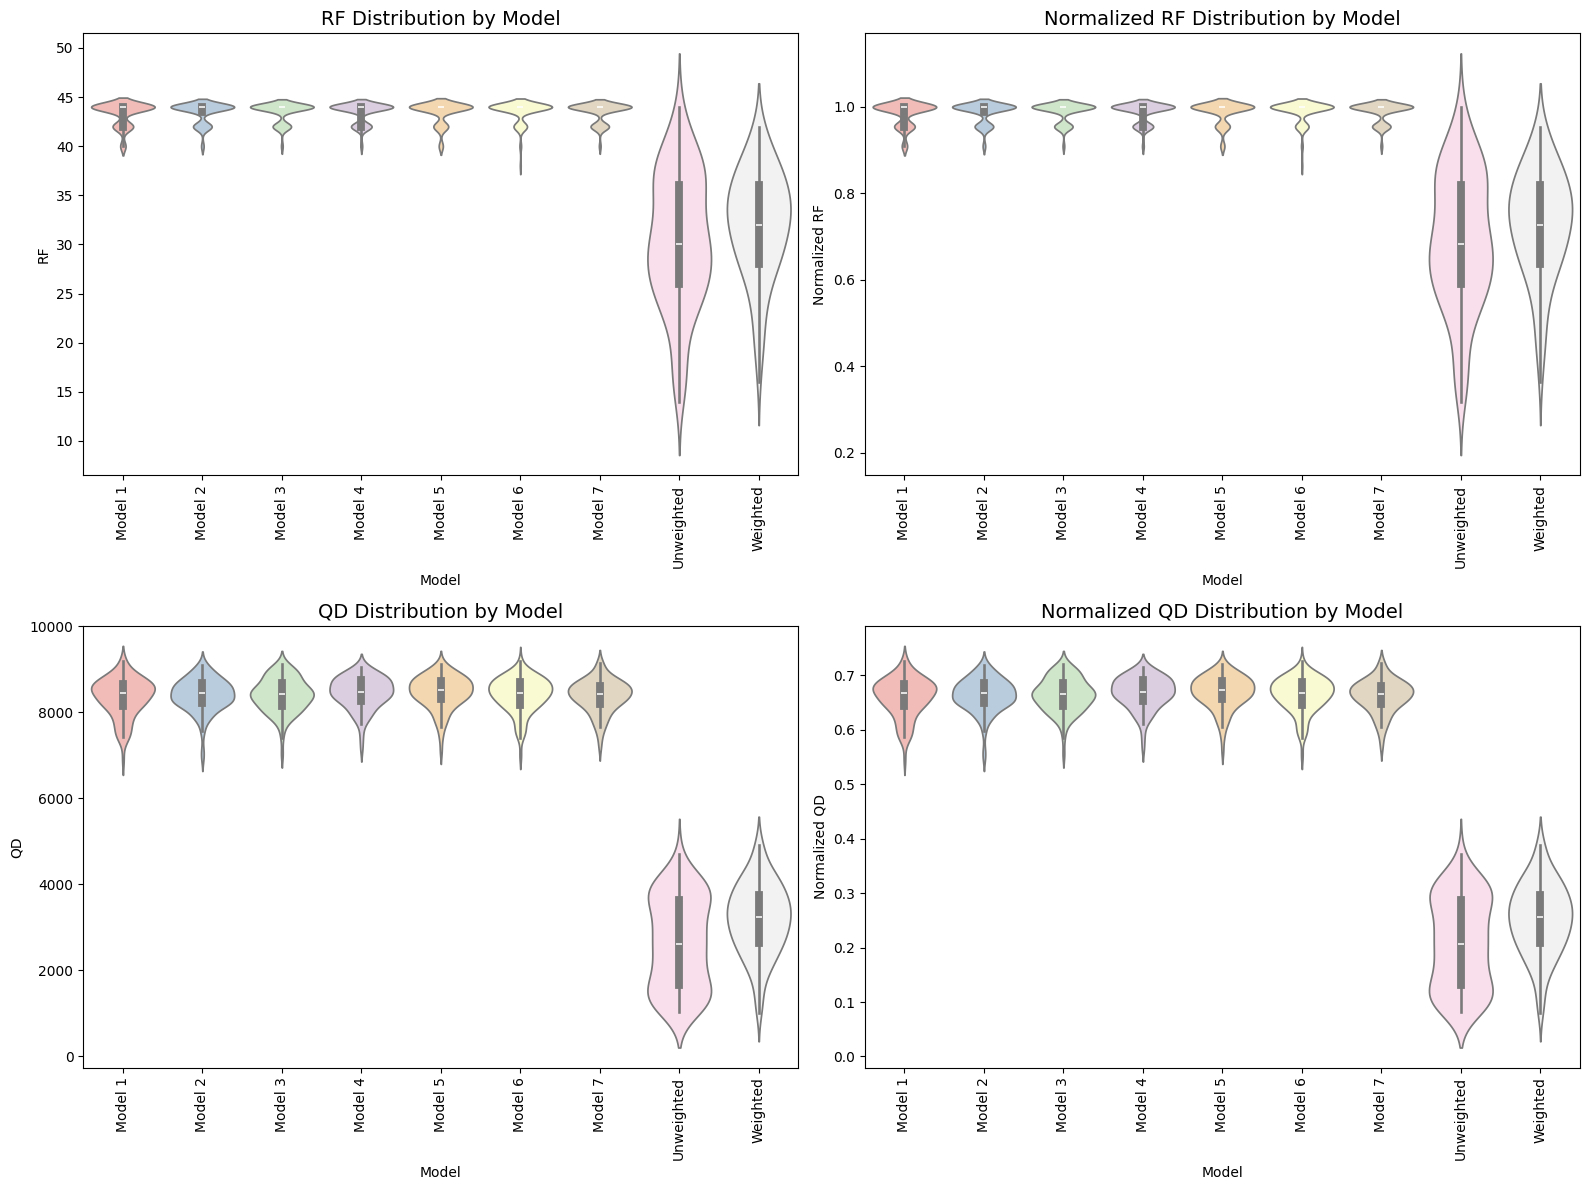

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 모델 이름
n_existing = len(models)
model_labels_all = [f"Model {i+1}" for i in range(n_existing)] + ["Unweighted", "Weighted"]

# long-form 데이터 생성 함수
def make_long_df(data_list, model_labels, metric_name):
    df = pd.DataFrame({
        "Value": [v for model in data_list for v in model],
        "Model": [model_labels[i] for i, model in enumerate(data_list) for _ in model]
    })
    df["Metric"] = metric_name
    return df

# long-form 데이터
df_rf = make_long_df(rf_distances_all, model_labels_all, "RF")
df_nrf = make_long_df(nrf_distances_all, model_labels_all, "Normalized RF")
df_qd = make_long_df(qds_all, model_labels_all, "QD")
df_nqd = make_long_df(nqds_all, model_labels_all, "Normalized QD")

df_all = pd.concat([df_rf, df_nrf, df_qd, df_nqd], ignore_index=True)

# -----------------------------
# 2x2 subplot 그리기
# -----------------------------
metrics = ["RF", "Normalized RF", "QD", "Normalized QD"]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    df_plot = df_all[df_all["Metric"] == metric]
    sns.violinplot(
        x="Model",
        y="Value",
        data=df_plot,
        inner="box",
        palette="Pastel1",
        order=model_labels_all,
        ax=ax
    )
    ax.set_title(f"{metric} Distribution by Model", fontsize=14)
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# 🔚 End of Notebook

# 3. Kuhn 2011 Method Result

- Data: 
  - Title: A quantitative model of normal C. elegans embryogenesis and its disruption after stress
  - doi: https://doi.org/10.1016/j.ydbio.2012.11.034
    - Supplementary Table 1: List of all strains, embryos and conditions used for these analyses along with statistics about lineaging depth and developmental rate.

Method
- Read `NIHMS428096-supplement-03.xlsx` and apply to tree.
- Convert the names into `Zappaapppa...` form.
- Apply the branch length.
- Delete the descendants if the branch has zero length.

* AB, P1 time = 0 (Sulston 1983)

## 1. Draw Lengthed Tree

In [106]:
import pandas as pd

# 엑셀 파일 읽기
file_path = "csv/NIHMS428096-supplement-03.xlsx"  # 실제 파일 경로로 바꿔주세요
df = pd.read_excel(file_path)

# 데이터 확인
print(df.columns)  # 컬럼명 확인

Index(['Cell',
       'Mean division time (minutes at 22 degrees C).  Start times aligned to ABala division = 74' ',
       'Mean division time (minutes) - normalized to Sulston rate (20 degrees C)',
       'Mean cell cycle length (minutes) - normalized to Sulston rate (20 degrees C)',
       'Division Time Stdev (minutes at 20C)',
       'Cell Cycle Stdev (minutes at 20C)', 'Division Time CV',
       'Cell Cycle CV', '# of embryos in which division was observed',
       '# of embryos in which birth was observed',
       'Mean Movement rate (microns per minute)',
       'Mean movement distance (microns)'],
      dtype='object')


In [107]:
cell_time = df[['Cell', 'Mean division time (minutes) - normalized to Sulston rate (20 degrees C)',]]

# cell_time 열 이름 변경
cell_time = cell_time.rename(columns={
    'Cell': 'name',
    'Mean division time (minutes) - normalized to Sulston rate (20 degrees C)': 'time'
})

# 확인
print(cell_time.columns)
print(cell_time.shape)

print(cell_time.columns)
print(cell_time.shape)

Index(['name', 'time'], dtype='object')
(1183, 2)
Index(['name', 'time'], dtype='object')
(1183, 2)


In [108]:
# cell_time 복사
cell_time_new = cell_time.copy()

# mapping: 원래 name → Zap 이름(Lineage Name)
mapping = dict(zip(z_only_df_unique['Cell'], z_only_df_unique['Lineage Name']))

# 이름 치환
cell_time_new['name'] = cell_time_new['name'].map(mapping).fillna(cell_time_new['name'])

# 중복된 이름 제거(원하시면 고유화 없이 삭제)
cell_time_new = cell_time_new[~cell_time_new['name'].duplicated(keep=False)]

# division time NaN 제거
cell_time_new = cell_time_new.dropna(subset=['time'])

In [109]:
import pandas as pd
import re

# 예시: cell_time['name'] 사용
# cell_time = pd.DataFrame({'name': ['ABa','ABp','EMS','P2','ABal','ABar','ABpl','ABpr','Zpaa','Zpap'],
#                           'time': [42,42,45,47,55,55,55,55,61,62]})

# 1. 각 Cell(name)에서 소문자 아닌 부분만 추출
cell_prefixes = cell_time['name'].apply(lambda x: ''.join(re.findall(r'[^a-z]', x)))

# 2. 등장 횟수 계산
counts = cell_prefixes.value_counts()

# 3. 1번 이상 등장하는 값 선택 (Zap 변환 대상 prefix)
at_least_once_prefixes = counts[counts >= 1].index.tolist()

# 확인
print(at_least_once_prefixes)

['AB', 'MS', 'C', 'E', 'D', 'EMS', 'P2', 'P3', 'P4', 'Z2', 'Z3']


In [110]:
for cell in at_least_once_prefixes:
    # z_only_df_unique에서 Cell이 일치하는 행 찾기
    match = z_only_df_unique[z_only_df_unique['Cell'] == cell]
    if not match.empty:
        lineage = match['Lineage Name'].values[0]
    else:
        lineage = ""  # 없으면 빈 문자열
    print(f"Cell: {cell}, Lineage: {lineage}")

Cell: AB, Lineage: Za
Cell: MS, Lineage: Zpaa
Cell: C, Lineage: Zppa
Cell: E, Lineage: Zpap
Cell: D, Lineage: Zpppa
Cell: EMS, Lineage: Zpa
Cell: P2, Lineage: Zpp
Cell: P3, Lineage: Zppp
Cell: P4, Lineage: Zpppp
Cell: Z2, Lineage: Zppppp
Cell: Z3, Lineage: Zppppa


In [111]:
import pandas as pd
import re

# 1️⃣ cell_time 불러오기 또는 기존 DataFrame 사용
# cell_time = pd.read_excel("your_file.xlsx")
# 열 이름은 'name', 'time'으로 정리되어 있다고 가정

# 2️⃣ mapping 준비: 원래 Cell prefix → Zap 이름(Lineage Name)
# z_only_df_unique는 preprocessing 후 CSV에서 불러온 DataFrame
# z_only_df_unique = pd.read_csv("csv/Complete_cell_list_preprocessed.csv")
# 여기서 'Cell'이 원래 prefix, 'Lineage Name'이 Zap 이름

mapping = dict(zip(z_only_df_unique['Cell'], z_only_df_unique['Lineage Name']))

# 3️⃣ 이름 변환 함수: prefix가 mapping에 있으면 교체
def convert_cell_name(cell_name):
    # Cell에서 소문자 아닌 prefix 추출
    prefix_match = re.match(r'[^a-z]+', cell_name)
    if prefix_match:
        prefix = prefix_match.group()
        rest = cell_name[len(prefix):]  # 나머지 소문자 부분
        if prefix in mapping:
            return mapping[prefix] + rest.lower()
    return cell_name

# 4️⃣ 변환 적용
cell_time['name'] = cell_time['name'].apply(convert_cell_name)

# 5️⃣ 중복된 이름 삭제 (고유화 없이)
cell_time = cell_time[~cell_time['name'].duplicated(keep=False)]

# 6️⃣ division time NaN 삭제
cell_time = cell_time.dropna(subset=['time'])

# Z 루트 추가 (division time 0) #AB = Za, P1 = Zp
cell_time = pd.concat([pd.DataFrame([{'name': 'Z', 'time': 1}]), cell_time], ignore_index=True)
cell_time = pd.concat([pd.DataFrame([{'name': 'Za', 'time': 20}]), cell_time], ignore_index=True)
cell_time = pd.concat([pd.DataFrame([{'name': 'Zp', 'time': 20}]), cell_time], ignore_index=True)

# CSV로 저장
output_path = "csv/cell_time_processed.csv"
cell_time.to_csv(output_path, index=False)

In [112]:
import pandas as pd

# 1️⃣ cell_time CSV 불러오기
cell_time = pd.read_csv("csv/cell_time_processed.csv")  # 'name', 'time'
valid_cells = set(cell_time['name'])

# 2️⃣ edge CSV 불러오기
edges_df = pd.read_csv("csv/edges_list_all.csv")  # 'from','to'

# 3️⃣ cell_time에 있는 노드만 필터링
filtered_edges = edges_df[
    edges_df['from'].isin(valid_cells) & edges_df['to'].isin(valid_cells)
].copy()

# 필터링된 edge 저장
filtered_edges_output_path = "csv/edges_filtered.csv"
filtered_edges.to_csv(filtered_edges_output_path, index=False)
print(f"필터링된 edge를 '{filtered_edges_output_path}'에 저장했습니다.")

print(f"원본 edge 수: {len(edges_df)}")
print(f"필터링 후 edge 수: {len(filtered_edges)}")
print("필터링된 edge 예시:")
print(filtered_edges.head())

# 4️⃣ 필터링 후 남은 노드 확인
filtered_nodes = set(filtered_edges['from']).union(set(filtered_edges['to']))
print(f"필터링 후 남은 노드 수: {len(filtered_nodes)}")
print("노드 예시:", list(filtered_nodes)[:10])

# 5️⃣ root 'Z'가 있는지 확인
if 'Z' in filtered_nodes:
    print("루트 Z가 존재합니다.")
else:
    print("루트 Z가 필터링에서 제거되었습니다. Newick 생성 불가!")

필터링된 edge를 'csv/edges_filtered.csv'에 저장했습니다.
원본 edge 수: 2345
필터링 후 edge 수: 609
필터링된 edge 예시:
    from      to
0      Z      Za
1     Za     Zap
2    Zap    Zapl
3   Zapl   Zapla
4  Zapla  Zaplap
필터링 후 남은 노드 수: 610
노드 예시: ['Zaalpppaap', 'Zaalpaappa', 'Zaalaapaap', 'Zaprpappa', 'Zaalappppa', 'Zaplaaaap', 'Zpaaapppp', 'Zpaaappa', 'Zaprpppaap', 'Zaplaapapa']
루트 Z가 존재합니다.


In [113]:
import pandas as pd
from collections import defaultdict

# 1️⃣ cell_time 불러오기
cell_time = pd.read_csv("csv/cell_time_processed.csv")  # 'name','time'
time_dict = dict(zip(cell_time['name'], cell_time['time']))

# 2️⃣ 필터링된 edge 불러오기
edges_df = pd.read_csv("csv/edges_filtered.csv")  # 'from','to'

# 3️⃣ Z -> Za, Z -> Zp edge 추가
edges_df = pd.concat([
    edges_df,
    pd.DataFrame([{'from': 'Z', 'to': 'Za'}, {'from': 'Z', 'to': 'Zp'}])
], ignore_index=True)

# 4️⃣ 중복 제거
edges_df = edges_df.drop_duplicates(subset=['from','to']).reset_index(drop=True)

# 5️⃣ 모든 edge에 length 계산
def compute_length(row):
    try:
        if row['from'] == 'Z':  # 루트 바로 아래 edge는 0
            return 0.0
        return float(time_dict[row['to']] - time_dict[row['from']])
    except KeyError:
        print(f"Warning: {row['from']} or {row['to']} not in cell_time")
        return 0.0

edges_df['length'] = edges_df.apply(compute_length, axis=1)

# 6️⃣ 트리 딕셔너리 생성
tree_dict = defaultdict(list)
for _, row in edges_df.iterrows():
    tree_dict[row['from']].append((row['to'], row['length']))

# 7️⃣ 재귀적으로 Newick 생성 (branch length 포함)
def build_newick_with_length(node):
    if node not in tree_dict or len(tree_dict[node]) == 0:
        return node
    children_newick = [
        f"{build_newick_with_length(child)}:{length:.2f}" 
        for child, length in tree_dict[node]
    ]
    return "(" + ",".join(children_newick) + ")" + node

# 8️⃣ 루트부터 Newick 생성
root = 'Z'
newick_str = build_newick_with_length(root) + ";"
print(newick_str)

# 9️⃣ 파일 저장
newick_path = "nwk/tree_filtered_with_length.nwk"
with open(newick_path, "w") as f:
    f.write(newick_str)

(((((((((Zaplapaaaa:80.00,Zaplapaaap:77.00)Zaplapaaa:50.00,Zaplapaap:54.00)Zaplapaa:40.00,((Zaplapappp:89.00)Zaplapapp:48.00,Zaplapapa:51.00)Zaplapap:36.00)Zaplapa:30.00,(((Zaplapppap:71.00,Zaplapppaa:97.00)Zaplapppa:56.00,Zaplapppp:55.00)Zaplappp:41.00,(Zaplappaa:51.00,Zaplappap:51.00)Zaplappa:38.00)Zaplapp:31.00)Zaplap:28.00,((((Zaplaapapp:65.00,Zaplaapapa:88.00)Zaplaapap:49.00,(Zaplaapaap:73.00,Zaplaapaaa:85.00)Zaplaapaa:51.00)Zaplaapa:39.00,(Zaplaappa:54.00,Zaplaappp:47.00)Zaplaapp:35.00)Zaplaap:31.00,(((Zaplaaaaaa:93.00,Zaplaaaaap:64.00)Zaplaaaaa:53.00,Zaplaaaap:51.00)Zaplaaaa:38.00,(Zaplaaapp:50.00,Zaplaaapa:57.00)Zaplaaap:39.00)Zaplaaa:32.00)Zaplaa:27.00)Zapla:18.00,(((((Zaplppaapp:79.00,Zaplppaapa:86.00)Zaplppaap:52.00,(Zaplppaaaa:62.00)Zaplppaaa:56.00)Zaplppaa:43.00,((Zaplppapap:89.00,Zaplppapaa:70.00)Zaplppapa:51.00,(Zaplppappa:79.00,Zaplppappp:90.00)Zaplppapp:55.00)Zaplppap:40.00)Zaplppa:32.00,(((Zaplpppaaa:81.00,Zaplpppaap:77.00)Zaplpppaa:50.00,(Zaplpppapa:55.00)Zaplpppap:5

In [114]:
from Bio import Phylo

# Newick 읽기
tree = Phylo.read("nwk/tree_filtered_with_length.nwk", "newick")

# 모든 노드(flatten)
all_nodes = list(tree.get_terminals()) + list(tree.get_nonterminals())

# 이름 매핑
for i, node in enumerate(all_nodes, start=1):
    node.name = f"t_{i}"

# 저장
Phylo.write(tree, "tree_filtered_with_length_all_ti.nwk", "newick")

1

In [115]:
 
def calc_node_heights(clade, current_height=0, heights=None):
    if heights is None:
        heights = {}
    heights[clade] = current_height
    for child in clade.clades:
        branch_len = child.branch_length if child.branch_length else 0
        calc_node_heights(child, current_height + branch_len, heights)
    return heights

heights = calc_node_heights(tree.root)

# 3. 결과 확인
for node, h in heights.items():
    name = node.name if node.name else "internal"
    # print(f"{name}: {h}")

# 4. root height 확인
root_height = max(heights.values())
print("Root height:", root_height)

Root height: 342.0


## 2. Parameter Estimation by BEAST
- $\lambda - \mu$
- $\mu / \lambda$

### 2.1. `R` file 1

cat('\t\t<scaleOperator scaleFactor="0.75" weight="3">\n')
cat('\t\t\t<parameter idref="birthDeath.meanGrowthRate"/>\n')
cat('\t\t</scaleOperator>\n')
cat('\t\t<scaleOperator scaleFactor="0.75" weight="3">\n')
cat('\t\t\t<parameter idref="birthDeath.relativeDeathRate"/>\n')
cat('\t\t</scaleOperator>\n')

converts to the below

cat('\t\t<randomWalkOperator windowSize="0.1" weight="3">\n')
cat('\t\t\t<parameter idref="birthDeath.relativeDeathRate"/>\n')
cat('\t\t</randomWalkOperator>\n')
cat('\t\t<randomWalkOperator windowSize="0.1" weight="3">\n')
cat('\t\t\t<parameter idref="birthDeath.meanGrowthRate"/>\n')
cat('\t\t</randomWalkOperator>\n')

cat('\t<!-- Node Age Priors                                                         -->\n')
for (i in 1:length(clade.list)) {
		group <- paste("group", i, sep = "")
		cat("\t\t\t\t",'<uniformPrior lower=','"',branching.times(phy)[i]-error,'"',' upper=','"',branching.times(phy)[i]+error,'"','>',"\n",sep="")
		cat("\t\t\t\t\t",'<tmrcaStatistic idref=','"','tmrca(',group,')','"','/>',"\n",sep="")
		cat("\t\t\t\t",'</uniformPrior>',"\n",sep="")
	}

converts to the below

for (i in 1:length(clade.list)) {
    group <- paste("group", i, sep = "")
    # 음수 범위 방지
    lower <- 0
    upper <- 400 # tree depth = 362정도라서
    cat("\t\t\t\t", '<uniformPrior lower="', lower, '" upper="', upper, '">', "\n", sep="")
    cat("\t\t\t\t\t", '<tmrcaStatistic idref="', 'tmrca(', group, ')"', '/>', "\n", sep="")
    cat("\t\t\t\t", '</uniformPrior>', "\n", sep="")
}

In [116]:
%%R
library(ape)


all.clades <- function(phy) {

	foo <- function (x, phy, tip.labels = TRUE) 
			{
			if (class(phy) != "phylo") 
			stop("Phylogeny required")
			if (!(x %in% as.numeric(phy$edge))) 
			stop("Node not in range for phylogeny")

			while (any(x > min(phy$edge[,1])-1)) {

			maxx.loc <- which(x == max(x))
			maxx <- x[maxx.loc]
			x <- x[-maxx.loc]
			newx <- as.numeric(phy$edge[, 2][which(phy$edge[, 1] == maxx)])
			x <- c(x, newx)
			}

	x <- unique(x)
	if (tip.labels) {return(phy$tip.label[x])} else {return(x)}
	}


    nodes <- sort(unique(as.numeric(phy$edge)))
    nodes <- nodes[nodes > min(phy$edge[,1])-1]
    clade.list <- lapply(nodes, foo, phy=phy)
    
    return(clade.list)
    }

PolytomyResolver <- function(phy, error=0.001, file.out="") {

sink(paste(file.out, ".xml", sep=""))

    clade.list <- all.clades(phy)
    group <- paste("group", 1:length(clade.list), sep = "")

cat('<?xml version="1.0" standalone="yes"?>\n')
cat("<!-- Generated by Polytomy Resolver v1.0                             -->\n")
cat("<!--   by Tyler Kuhn, Gavin Thomas and Arne Mooers                   -->\n")
cat("<!--                                                                 -->\n")
cat("<!--   For resolving polytomous nodes in a dated tree                -->\n")
cat("<!--    under a Birth-Death model                                    -->\n")
cat("<beast>","\n")
cat("\t<!-- The list of taxa analyse (can also include dates/ages).                 -->\n")
cat("\t<!-- ntax=",length(clade.list[[1]]),"                                                                 -->\n",sep="")
cat('\t<taxa id="taxa">\n')
for (j in 1:length(clade.list[[1]])) {
		cat("\t\t",'<taxon id="',clade.list[[1]][j],'"','/>',"\n", sep="")
	}
cat("\t",'</taxa>',"\n", sep="")

cat("\n")
cat('<!-- Constraints - Begin monophyly constraints -->\n')
cat("\n")
	
for (i in 1:length(clade.list)) {
        group <- paste("group", i, sep = "")
        taxa <- clade.list[[i]]
        cat("\t",'<taxa id=','"',group,'"','>',"\n",sep="")
		for (j in 1:length(clade.list[[i]])) {
    		cat("\t\t",'<taxon idref=','"',clade.list[[i]][j],'"','/>',"\n", sep="")
    	}
		cat("\t",'</taxa>',"\n", sep="")
    }
	
cat("\n")
cat('<!-- Constraints - End monophyly constraints -->\n')
cat("\n")
	
cat('\t<alignment id="alignment" dataType="nucleotide">\n')
for (i in 1:length(phy$tip.label)) {
		cat("\t\t<sequence>\n")
		cat("\t\t\t",'<taxon idref="',phy$tip.label[i],'"/>',"\n",sep="")
		cat("\t\t\tN\n")
		cat("\t\t</sequence>\n")
	}
cat("\t</alignment>\n")
cat("\t<!-- The unique patterns from 1 to end                                       -->\n")
cat("\t<!-- npatterns=0                                                             -->\n")
cat('\t<patterns id="patterns" from="1">\n')
cat('\t\t<alignment idref="alignment"/>\n')
cat("\t</patterns>\n")
cat("\t<!-- A prior on the distribution node heights defined given                  -->\n")
cat("\t<!-- a Birth-Death speciation process (Gernhard 2008).                       -->\n")
cat('\t<birthDeathModel id="birthDeath" units="substitutions">\n')
cat("\t\t<birthMinusDeathRate>\n")
cat('\t\t\t<parameter id="birthDeath.meanGrowthRate" value="0.7" lower="0.0" upper="Infinity"/>\n')
cat("\t</birthMinusDeathRate>\n")
cat("\t\t<relativeDeathRate>\n")
cat('\t\t\t<parameter id="birthDeath.relativeDeathRate" value="0.5" lower="0.0" upper="Infinity"/>\n')
cat("\t\t</relativeDeathRate>\n")
cat("\t</birthDeathModel>\n")
cat("\t<!-- This is a simple constant population size coalescent model              -->\n")
cat("\t<!-- that is used to generate an initial tree for the chain.                 -->\n")
cat('\t<constantSize id="initialDemo" units="substitutions">\n')
cat("\t\t<populationSize>\n")
cat('\t\t\t<parameter id="initialDemo.popSize" value="100.0"/>\n')
cat("\t\t</populationSize>\n")
cat("\t\t</constantSize>\n")
	
cat("\n")
cat('<!-- Constraints - Begin Start Tree -->\n')
cat("\n")
cat('\t<!-- The starting tree.                                                      -->\n')
cat('\t<newick id="startingTree">\n')
cat("\t\t",write.tree(phy),"\n",sep="")
cat('\t</newick>\n')
	
cat("\n")
cat('<!-- Constraints - End Start Tree -->\n')
cat("\n")
	
cat('\t<!-- Generate a tree model                                                   -->\n')
cat('\t<treeModel id="treeModel">\n')
cat('\t\t<coalescentTree idref="startingTree"/>\n')
cat('\t\t<rootHeight>\n')
cat('\t\t\t<parameter id="treeModel.rootHeight"/>\n')
cat('\t\t</rootHeight>\n')
cat('\t\t<nodeHeights internalNodes="true">\n')
cat('\t\t\t<parameter id="treeModel.internalNodeHeights"/>\n')
cat('\t\t</nodeHeights>\n')
cat('\t\t<nodeHeights internalNodes="true" rootNode="true">\n')
cat('\t\t\t<parameter id="treeModel.allInternalNodeHeights"/>\n')
cat('\t\t</nodeHeights>\n')
cat('\t</treeModel>\n')
cat('\t<!-- Generate a speciation likelihood for Yule or Birth Death                -->\n')
cat('\t<speciationLikelihood id="speciation">\n')
cat('\t\t<model>\n')
cat('\t\t\t<birthDeathModel idref="birthDeath"/>\n')
cat('\t\t</model>\n')
cat('\t\t<speciesTree>\n')
cat('\t\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t</speciesTree>\n')
cat('\t</speciationLikelihood>\n')
cat('\t<!-- The strict clock (Uniform rates across branches)                        -->\n')
cat('\t<strictClockBranchRates id="branchRates">\n')
cat('\t\t<rate>\n')
cat('\t\t\t<parameter id="clock.rate" value="1.0"/>\n')
cat('\t\t</rate>\n')
cat('\t</strictClockBranchRates>\n')
cat('\t<!-- The HKY substitution model (Hasegawa, Kishino & Yano, 1985)             -->\n')
cat('\t<HKYModel id="hky">\n')
cat('\t\t<frequencies>\n')
cat('\t\t\t<frequencyModel dataType="nucleotide">\n')
cat('\t\t\t\t<frequencies>\n')
cat('\t\t\t\t\t<parameter id="frequencies" value="0.25 0.25 0.25 0.25"/>\n')
cat('\t\t\t\t</frequencies>\n')
cat('\t\t\t</frequencyModel>\n')
cat('\t\t</frequencies>\n')
cat('\t\t<kappa>\n')
cat('\t\t\t<parameter id="kappa" value="1.0" lower="0.0" upper="Infinity"/>\n')
cat('\t\t</kappa>\n')
cat('\t</HKYModel>\n')
cat('\t<!-- site model                                                              -->\n')
cat('\t<siteModel id="siteModel">\n')
cat('\t\t<substitutionModel>\n')
cat('\t\t\t<HKYModel idref="hky"/>\n')
cat('\t\t</substitutionModel>\n')
cat('\t</siteModel>\n')
cat('\t<treeLikelihood id="treeLikelihood" useAmbiguities="false">\n')
cat('\t\t<patterns idref="patterns"/>\n')
cat('\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t<siteModel idref="siteModel"/>\n')
cat('\t\t<strictClockBranchRates idref="branchRates"/>\n')
cat('\t</treeLikelihood>\n')

cat("\n")
cat('\t<!-- Constraints - Begin Monophyly statistics -->\n')
cat("\n")
	for (i in 1:length(clade.list)) {
		group <- paste("group", i, sep = "")
		cat("\t",'<tmrcaStatistic id=','"','tmrca(',group,')','"','>',"\n", sep="")
		cat("\t\t",'<mrca>\n', sep="")
		cat("\t\t\t",'<taxa idref=','"',group,'"','/>',"\n", sep="")
		cat("\t\t",'</mrca>\n', sep="")
		cat("\t\t",'<treeModel idref=','"','treeModel','"','/>',"\n", sep="")
		cat("\t",'</tmrcaStatistic>\n', sep="")
		cat("\t",'<monophylyStatistic id=','"','monophyly(',group,')','"','>',"\n", sep="")
		cat("\t\t",'<mrca>\n', sep="")
		cat("\t\t\t",'<taxa idref=','"',group,'"','/>',"\n", sep="")
		cat("\t\t",'</mrca>\n', sep="")
		cat("\t\t",'<treeModel idref=','"','treeModel','"','/>',"\n", sep="")
		cat("\t",'</monophylyStatistic>\n', sep="")	}
cat("\n")
cat('\t<!-- Constraints - End Monophyly statistics -->\n')
cat("\n")	

cat('\t<!-- Define operators                                                        -->\n')
cat('\t<operators id="operators">\n')
cat('\t\t<subtreeSlide size="100.0" gaussian="true" weight="15">\n')
cat('\t\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t</subtreeSlide>\n')
cat('\t\t<narrowExchange weight="15">\n')
cat('\t\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t</narrowExchange>\n')
cat('\t\t<wideExchange weight="3">\n')
cat('\t\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t</wideExchange>\n')
cat('\t\t<wilsonBalding weight="3">\n')
cat('\t\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t</wilsonBalding>\n')
cat('\t\t<scaleOperator scaleFactor="0.75" weight="3">\n')
cat('\t\t\t<parameter idref="treeModel.rootHeight"/>\n')
cat('\t\t</scaleOperator>\n')
cat('\t\t<uniformOperator weight="30">\n')
cat('\t\t\t<parameter idref="treeModel.internalNodeHeights"/>\n')
cat('\t\t</uniformOperator>\n')

#cat('\t\t<scaleOperator scaleFactor="0.75" weight="3">\n')
#cat('\t\t\t<parameter idref="birthDeath.meanGrowthRate"/>\n')
#cat('\t\t</scaleOperator>\n')
#cat('\t\t<scaleOperator scaleFactor="0.75" weight="3">\n')
#cat('\t\t\t<parameter idref="birthDeath.relativeDeathRate"/>\n')
#cat('\t\t</scaleOperator>\n')
# converts to the below
cat('\t\t<randomWalkOperator windowSize="0.1" weight="3">\n')
cat('\t\t\t<parameter idref="birthDeath.relativeDeathRate"/>\n')
cat('\t\t</randomWalkOperator>\n')

cat('\t\t<randomWalkOperator windowSize="0.2" weight="3">\n')
cat('\t\t\t<parameter idref="birthDeath.meanGrowthRate"/>\n')
cat('\t\t</randomWalkOperator>\n')

cat('\t\t<upDownOperator scaleFactor="0.75" weight="3">\n')
cat('\t\t\t<up>\n')
cat('\t\t\t</up>\n')
cat('\t\t\t<down>\n')
cat('\t\t\t\t<parameter idref="treeModel.allInternalNodeHeights"/>\n')
cat('\t\t\t</down>\n')
cat('\t\t</upDownOperator>\n')
cat('\t\t</operators>\n')
cat('\t<!-- Define MCMC                                                             -->\n')
cat('\t<mcmc id="mcmc" chainLength="1000000" autoOptimize="true">\n')
cat('\t\t<posterior id="posterior">\n')
cat('\t\t\t<prior id="prior">\n')
cat('\t\t\t\t<gammaPrior shape="0.05" scale="40.0" offset="0.0">\n')
cat('\t\t\t\t\t<parameter idref="kappa"/>\n')
cat('\t\t\t\t</gammaPrior>\n')
cat('\t\t\t\t<speciationLikelihood idref="speciation"/>\n')

cat("\n")
cat('\t<!-- Constraints - Begin Boolean Likelihood -->\n')
cat("\n")
	
cat("\t\t\t\t",'<booleanLikelihood>\n', sep="")
for (i in 1:length(clade.list)) {
		group <- paste("group", i, sep = "")
		cat("\t\t\t\t\t",'<monophylyStatistic idref=','"','monophyly(',group,')','"','/>',"\n", sep="")
    }
cat("\t\t\t\t",'</booleanLikelihood>\n', sep="")


# cat('\t<!-- Node Age Priors                                                         -->\n')
# for (i in 1:length(clade.list)) {
# 		group <- paste("group", i, sep = "")
# 		cat("\t\t\t\t",'<uniformPrior lower=','"',branching.times(phy)[i]-error,'"',' upper=','"',branching.times(phy)[i]+error,'"','>',"\n",sep="")
# 		cat("\t\t\t\t\t",'<tmrcaStatistic idref=','"','tmrca(',group,')','"','/>',"\n",sep="")
# 		cat("\t\t\t\t",'</uniformPrior>',"\n",sep="")
# 	}

# Node Age Priors (Safe version)
for (i in 1:length(clade.list)) {
    group <- paste("group", i, sep = "")
    # 음수 범위 방지
    lower <- 0
    upper <- ceiling(max(branching.times(phy)))
    cat("\t\t\t\t", '<uniformPrior lower="', lower, '" upper="', upper, '">', "\n", sep="")
    cat("\t\t\t\t\t", '<tmrcaStatistic idref="', 'tmrca(', group, ')"', '/>', "\n", sep="")
    cat("\t\t\t\t", '</uniformPrior>', "\n", sep="")
}


	
cat("\n")
cat('\t<!-- Constraints - End Boolean Likelihood -->\n')
cat("\n")
	
cat('\t\t\t</prior>\n')
cat('\t\t\t<likelihood id="likelihood">\n')
cat('\t\t\t\t<treeLikelihood idref="treeLikelihood"/>\n')
cat('\t\t\t</likelihood>\n')
cat('\t\t</posterior>\n')
cat('\t\t<operators idref="operators"/>\n')
cat('\t\t<!-- write log to screen                                                     -->\n')
cat('\t\t<log id="screenLog" logEvery="1000">\n')
cat('\t\t\t<column label="Posterior" dp="4" width="12">\n')
cat('\t\t\t\t<posterior idref="posterior"/>\n')
cat('\t\t\t</column>\n')
cat('\t\t\t<column label="Prior" dp="4" width="12">\n')
cat('\t\t\t\t<prior idref="prior"/>\n')
cat('\t\t\t</column>\n')
cat('\t\t\t<column label="Likelihood" dp="4" width="12">\n')
cat('\t\t\t\t<likelihood idref="likelihood"/>\n')
cat('\t\t\t</column>\n')
cat('\t\t\t<column label="rootHeight" sf="6" width="12">\n')
cat('\t\t\t\t<parameter idref="treeModel.rootHeight"/>\n')
cat('\t\t\t</column>\n')
cat('\t\t\t<column label="clock.rate" sf="6" width="12">\n')
cat('\t\t\t\t<parameter idref="clock.rate"/>\n')
cat('\t\t\t</column>\n')
cat('\t\t</log>\n')
	
cat('\t\t<log id="fileLog" logEvery="1000" fileName="',file.out,'.log">\n',sep="")
cat('\t\t\t<posterior idref="posterior"/>\n')
cat('\t\t\t<prior idref="prior"/>\n')
cat('\t\t\t<likelihood idref="likelihood"/>\n')
cat('\t\t\t<parameter idref="treeModel.rootHeight"/>\n')
cat('\t\t\t<parameter idref="birthDeath.meanGrowthRate"/>\n')
cat('\t\t\t<parameter idref="birthDeath.relativeDeathRate"/>\n')
cat('\t\t\t<parameter idref="kappa"/>\n')
cat('\t\t\t<parameter idref="frequencies"/>\n')
cat('\t\t\t<parameter idref="clock.rate"/>\n')
cat('\t\t\t<treeLikelihood idref="treeLikelihood"/>\n')
cat('\t\t\t<speciationLikelihood idref="speciation"/>\n')
cat('\t\t</log>\n')
cat('\t\t<!-- write tree log to file                                                  -->\n')
cat('\t\t<logTree id="treeFileLog" logEvery="1000" nexusFormat="true" fileName="',file.out,'.trees" sortTranslationTable="true">\n',sep="")
cat('\t\t\t<treeModel idref="treeModel"/>\n')
cat('\t\t\t<strictClockBranchRates idref="branchRates"/>\n')
cat('\t\t\t<posterior idref="posterior"/>\n')
cat('\t\t</logTree>\n')
cat('\t</mcmc>\n')
cat('\t<report>\n')
cat('\t\t<property name="timer">\n')
cat('\t\t\t<mcmc idref="mcmc"/>\n')
cat('\t\t</property>\n')
cat('\t</report>\n')
cat('</beast>\n')

sink()



sink(paste(file.out, ".nex", sep=""))
cat("#NEXUS\n")
cat("\n")
cat("Begin DATA;\n")
cat("Dimensions ntax=",length(phy$tip.label)," nchar=1;\n", sep="")
cat("Format datatype=NUCLEOTIDE gap=-;\n")
cat("Matrix\n")

for (i in 1:length(phy$tip.label)) {
	cat(phy$tip.label[i],"\tN\n")
	}
cat(";\n")
cat("end;\n\n")
cat("Begin Trees;\n")
cat("\tTree StartTree = [&R] ",write.tree(phy),"\n",sep="")
cat("end;\n")
sink()

}

In [117]:
%%R
phy <- read.tree("nwk/tree_filtered_with_length_all_ti.nwk")

PolytomyResolver(
  phy, 
  error=0.001, 
  file.out="/Users/yongjunchoi/Documents/BEAST_test/output1"
)

여기까지 했는데, beast에서 자꾸 parameter가 발산해서 여기에서 멈춤.

# 4. Matrix to Phylogenetic tree

In [3]:
import numpy as np
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, _DistanceMatrix
from Bio import Phylo
from scipy.spatial.distance import pdist, squareform

np.random.seed(42)

# -----------------------------
# 1. 설정
# -----------------------------
num_leaves = 6
l_values = [1,2,3,1,2,3,2,1,1,2]  # mutation group size
delta_t = 0.5  # 테스트할 delta t 값

num_sites = len(l_values)

# -----------------------------
# 2. 랜덤 matrix 생성
# -----------------------------
def generate_matrix(l_values, delta_t, num_leaves):
    p_values = [0.5 * (1 - np.exp(-l*delta_t)) for l in l_values]
    matrix = np.random.binomial(1, p_values, size=(num_leaves, len(l_values)))
    return matrix

# -----------------------------
# 3. 재귀 binary column 선택
# -----------------------------
def select_binary_columns(subtree_leaves, columns):
    if len(subtree_leaves) <= 2:
        return []

    for col in columns:
        leaf_values = col[subtree_leaves]
        count_0 = np.sum(leaf_values == 0)
        count_1 = np.sum(leaf_values == 1)
        if count_0 >= 1 and count_1 >= 1:
            left_leaves = [i for i in subtree_leaves if col[i]==0]
            right_leaves = [i for i in subtree_leaves if col[i]==1]
            left_cols = select_binary_columns(left_leaves, columns)
            right_cols = select_binary_columns(right_leaves, columns)
            return [col] + left_cols + right_cols
    return []

# -----------------------------
# 4. Neighbor-Joining tree 생성
# -----------------------------
from Bio.Phylo.TreeConstruction import _DistanceMatrix, DistanceTreeConstructor
from scipy.spatial.distance import pdist

def build_tree(matrix):
    # Hamming distance
    dist_array = pdist(matrix, metric='hamming')  # condensed lower triangle
    leaf_names = [f"L{i+1}" for i in range(matrix.shape[0])]

    # _DistanceMatrix는 lower triangle list 형식 필요
    dm = _DistanceMatrix(leaf_names, dist_array.tolist())

    constructor = DistanceTreeConstructor()
    tree = constructor.nj(dm)
    return tree

# -----------------------------
# 5. 실행
# -----------------------------
matrix = generate_matrix(l_values, delta_t, num_leaves)
columns = [matrix[:,i] for i in range(num_sites)]
all_leaves = list(range(num_leaves))

binary_cols = select_binary_columns(all_leaves, columns)
if not binary_cols:
    print("No binary-informative columns found!")
else:
    # 선택된 column으로 새로운 matrix 생성
    selected_indices = [matrix.T.tolist().index(col.tolist()) for col in binary_cols]
    binary_matrix = matrix[:, selected_indices]

    print("Binary-informative matrix:\n", binary_matrix)

    # NJ tree 생성
    tree = build_tree(binary_matrix)

    # ASCII 출력
    print("\nNJ tree (ASCII):")
    Phylo.draw_ascii(tree)

    # Newick 출력
    from io import StringIO
    newick_io = StringIO()
    Phylo.write(tree, newick_io, "newick")
    newick_str = newick_io.getvalue().strip()
    print("\nNJ tree (Newick):")
    print(newick_str)

Binary-informative matrix:
 [[0 1 0]
 [0 1 0]
 [0 0 0]
 [0 0 1]
 [0 0 1]
 [1 1 1]]


TypeError: 'matrix' should be a list of numerical lists